# [NTDS'18] Final project
[ntds'18]: https://github.com/mdeff/ntds_2018

* Team: `4` ([github repo](https://github.com/swouf/ntds_IMDb_team4))
* Dataset: `IMDb Films and Crew`

### Authors :
+ [Julien Berger](mailto:juliengaetan.berger@epfl.ch)
+ [Jérémy Jayet](mailto:jeremy.jayet@epfl.ch)
+ [Hana Samet](mailto:hana.samet@epfl.ch)
+ [Mathieu Shiva](mailto:mathieu.shiva@epfl.ch)

## 0 - Import packages and data

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from scipy import sparse
import scipy.sparse.linalg
from matplotlib import pyplot as plt
from pyunlocbox import functions, solvers
import pygsp as pg
import networkx as nx
import logging
import json
import sys
import seaborn as sns

logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s',
                     level=logging.INFO, stream=sys.stdout)

import src.load_data as ldata

In [2]:
(movies,people,list_of_genres_id) = ldata.load_dataframes();

2019-01-13 18:52:55,279 | INFO : Data loaded !


In [ ]:
#Used to create a new feature matrix that contains only the actors (not the crew)
#features_actors=ldata.create_features(movies,people);

In [3]:
#the list that makes the conversion between numerical values and genres titles
list_genres=movies[['genres_names','genres']].copy()
list_genres=list_genres.drop_duplicates()
list_genres=list_genres.set_index('genres') 
list_genres

genres_names
genres                 
0                Action
1             Adventure
2               Fantasy
3             Animation
4       Science Fiction
5                 Drama
6              Thriller
7                Family
8                Comedy
9               History
10                  War
11              Western
12              Romance
13                Crime
14              Mystery
15               Horror
16          Documentary
17                Music
18             TV Movie
19              Unknown
20              Foreign

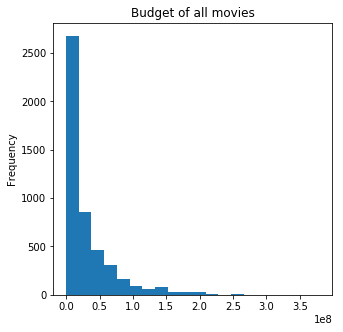

In [4]:
movies.budget.plot(kind='hist', bins = 20, figsize = (5,5))
plt.title('Budget of all movies')
plt.show()

In [5]:
data=movies['genres_names'].value_counts()
data

Drama              1207
Comedy             1042
Action              754
Adventure           339
Horror              300
Crime               195
Thriller            194
Animation           123
Fantasy             117
Romance             106
Science Fiction      96
Documentary          89
Family               56
Mystery              41
Music                34
Unknown              28
Western              27
History              25
War                  24
TV Movie              4
Foreign               2
Name: genres_names, dtype: int64

/home/jeremy/miniconda3/envs/ntds_2018/lib/python3.7/site-packages/matplotlib/legend.py:1364: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  warnings.warn("You have mixed positional and keyword "


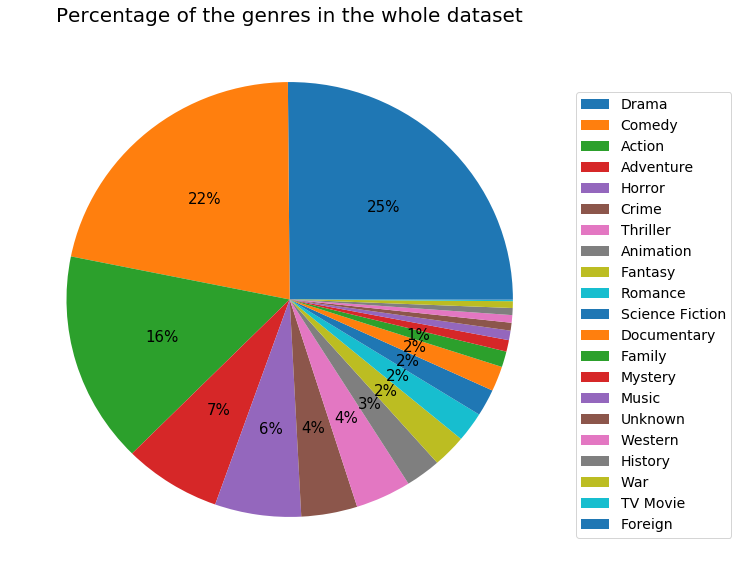

In [6]:
plt.figure(figsize = (10,10))
plt.pie(data, autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',labeldistance=1.1,startangle=0,textprops={'fontsize': 15})
plt.title('Percentage of the genres in the whole dataset',fontsize=20)
plt.legend(data,labels=movies['genres_names'].value_counts().index, bbox_to_anchor=(0.9,0.80), bbox_transform=plt.gcf().transFigure,prop={'size': 14})
plt.show()

In [7]:
#CODE TO GENERATE THE ADJACENCY MATRIX THAT CONNECTES MOVIES TOGETHER
#TAKE A LONG AMOUNT OF TIME, SO JUST USE adjacency_test=np.load('./data/adjacency_test_movies.npy')

#features_movies=ldata.load_features();
#adjacency_test=ldata.make_adjacency_from_feature_matrix(features_movies)
#np.save('./data/adjacency_actors_only', adjacency_test);
#adjacency_test

#The commented lines can be replaced by the line below --> the creation of the adjacency doesn't have to be done each time.
#adjacency_test=np.load('./data/adjacency_actors_only.npy')

#need to find a way to select only certain movies from the features ()

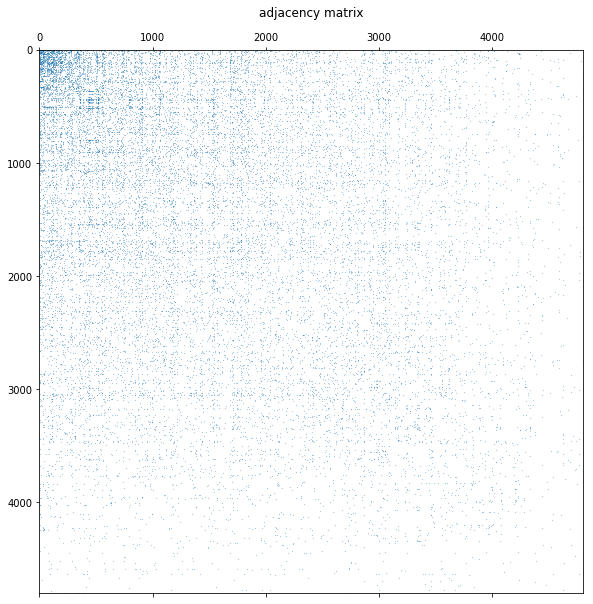

In [8]:
#adjacency using only the actors, not the crew

#LE CHOIX DE LA MATRICE EST IMPORTANTE, SURTOUT POUR LES DECADE AVEC PEU DE FILMS
#soit on utilise la version avec que des acteurs, soit la version avec acteurs et crew
adjacency_actors=np.load('./data/adjacency_actors_only.npy')
#adjacency_actors=np.load('./data/adjacency_actors_crew.npy')


#ON PEUT AUSSI AUGMENETER LE NOMBRE D'ACTEURS EN COMMUN NECESSAIRES
#adjacency_actors[adjacency_actors <2]=0

plt.figure(figsize=(10, 10))
plt.spy(adjacency_actors, markersize=0.1)
plt.title('adjacency matrix')

G_test = nx.from_numpy_matrix(adjacency_actors)
nx.number_connected_components(G_test)
Gc_test = max(nx.connected_component_subgraphs(G_test), key=len)
coords_test = nx.spring_layout(Gc_test,k=0.03)  # Force-directed layout.


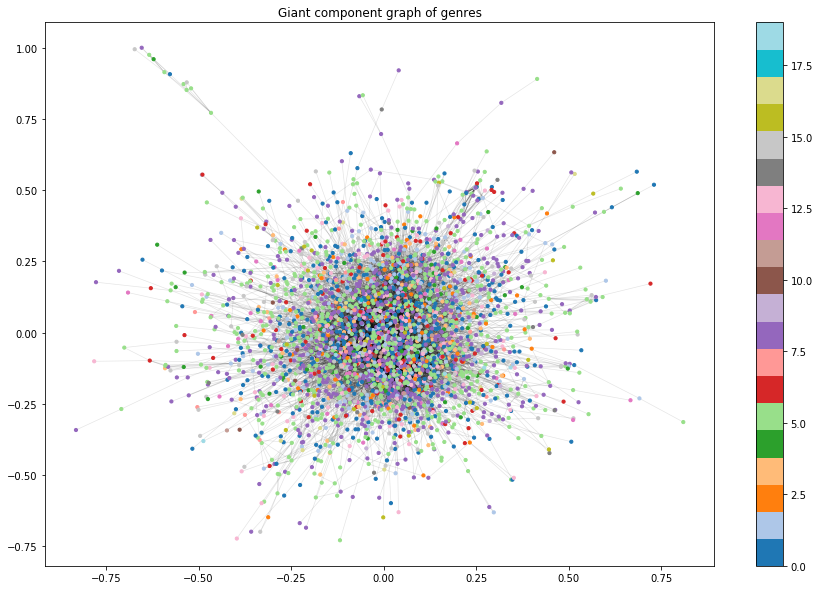

In [9]:
labels = movies['genres'].iloc[np.sort(nx.nodes(Gc_test))]
plt.figure(figsize=(15, 10))
im=nx.draw_networkx_nodes(Gc_test, coords_test, node_size=10,node_color=labels, cmap='tab20')
nx.draw_networkx_edges(Gc_test, coords_test, alpha=0.1, width=0.7)
plt.title('Giant component graph of genres')
plt.colorbar(im);

#action=0=bleu foncé
#comedy=8= mauve
#drama=5=vert clair

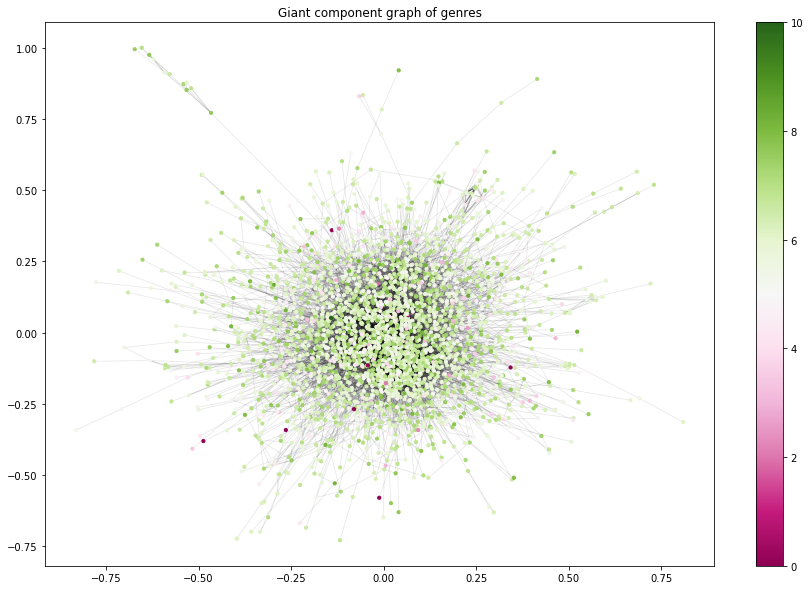

In [10]:
labels = movies['vote_average'].iloc[np.sort(nx.nodes(Gc_test))]
plt.figure(figsize=(15, 10))
im=nx.draw_networkx_nodes(Gc_test, coords_test, node_size=10,node_color=labels, cmap='PiYG')
nx.draw_networkx_edges(Gc_test, coords_test, alpha=0.1, width=0.7)
plt.title('Giant component graph of genres')
plt.colorbar(im);

In [11]:
numberOfDecades = 6

moviesFilteredByYears = []

for i in range(numberOfDecades):
    decade = 1960 + i*10
    decadeEnd = decade + 10
    moviesFilteredByYears.append(ldata.filter_movies_by_years(movies, pd.to_datetime(f'{decade}-01-01').date(), pd.to_datetime(f'{decadeEnd}-01-01').date()))

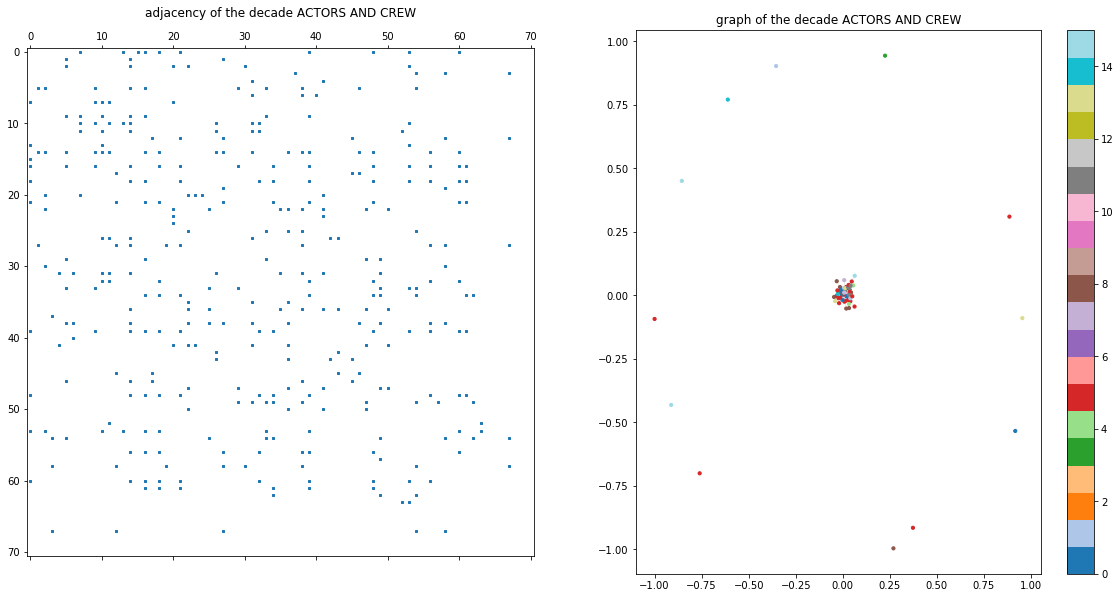

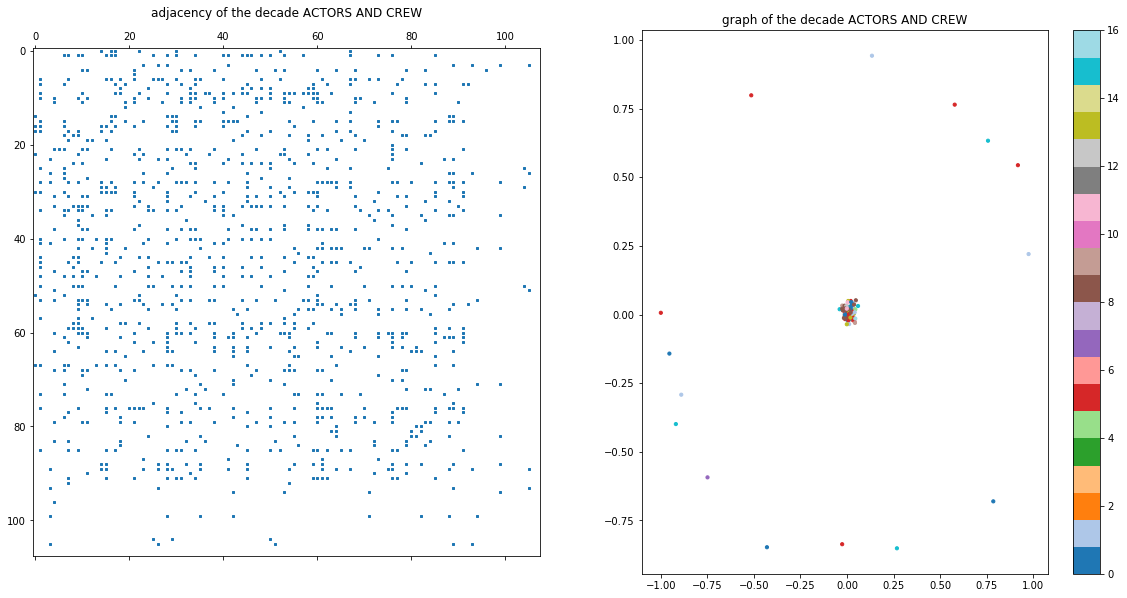

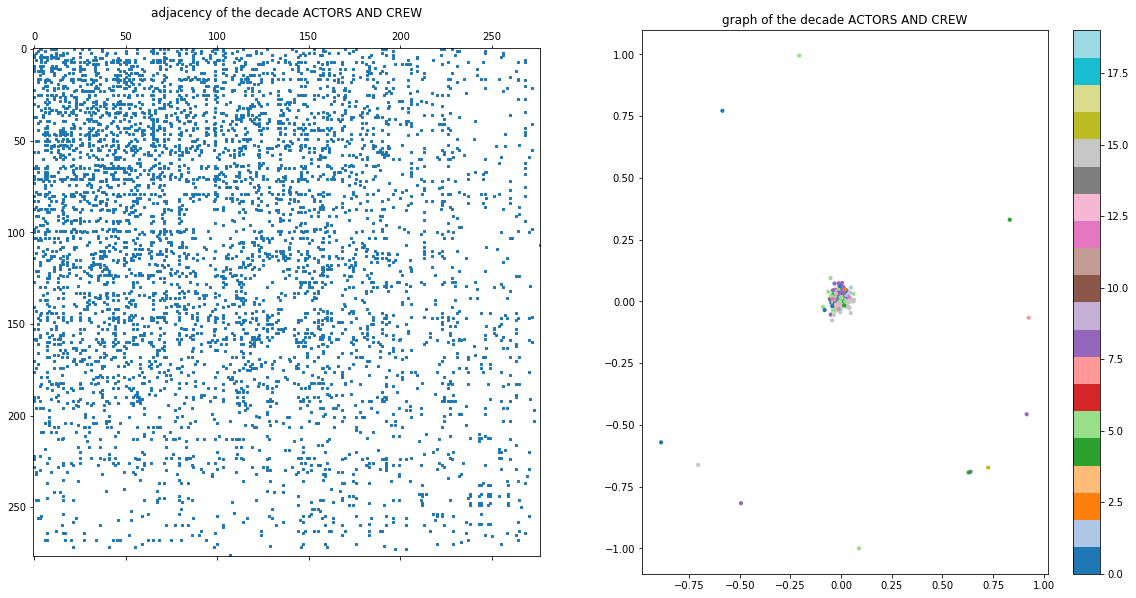

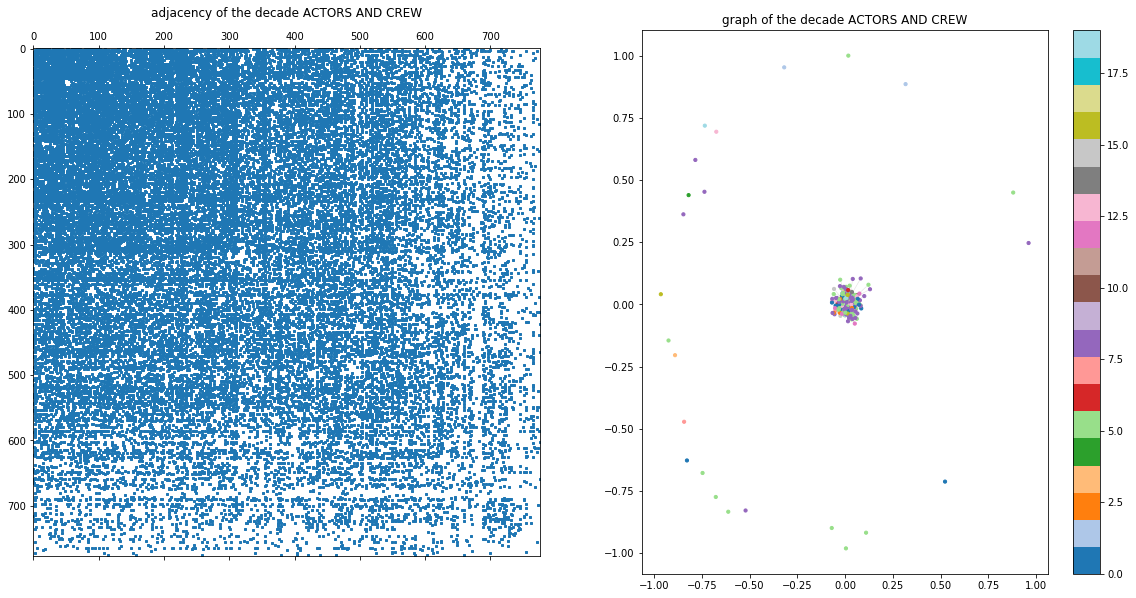

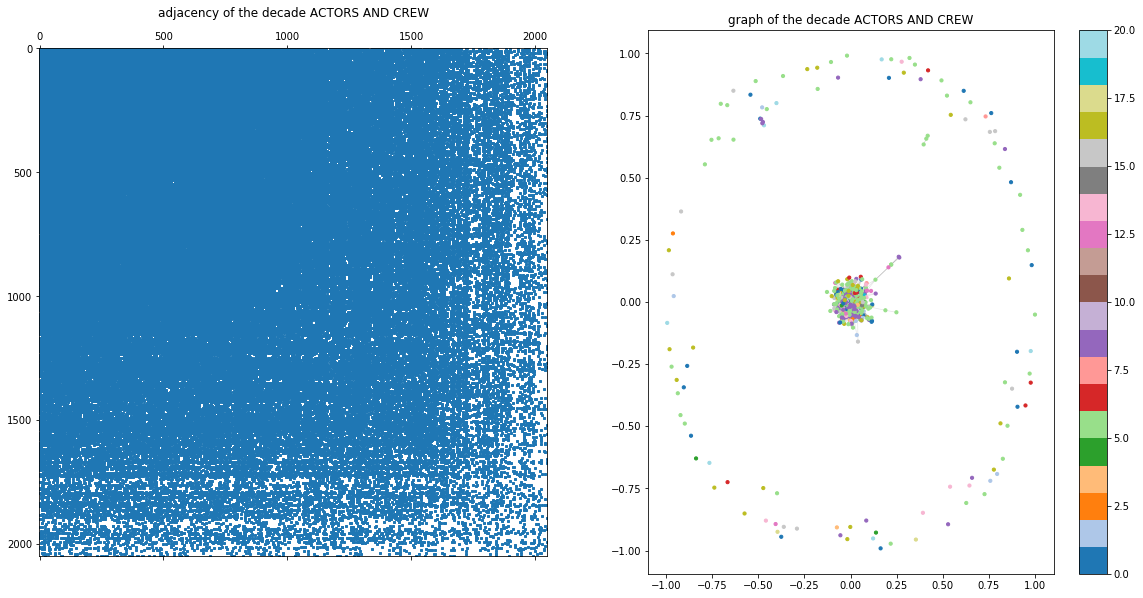

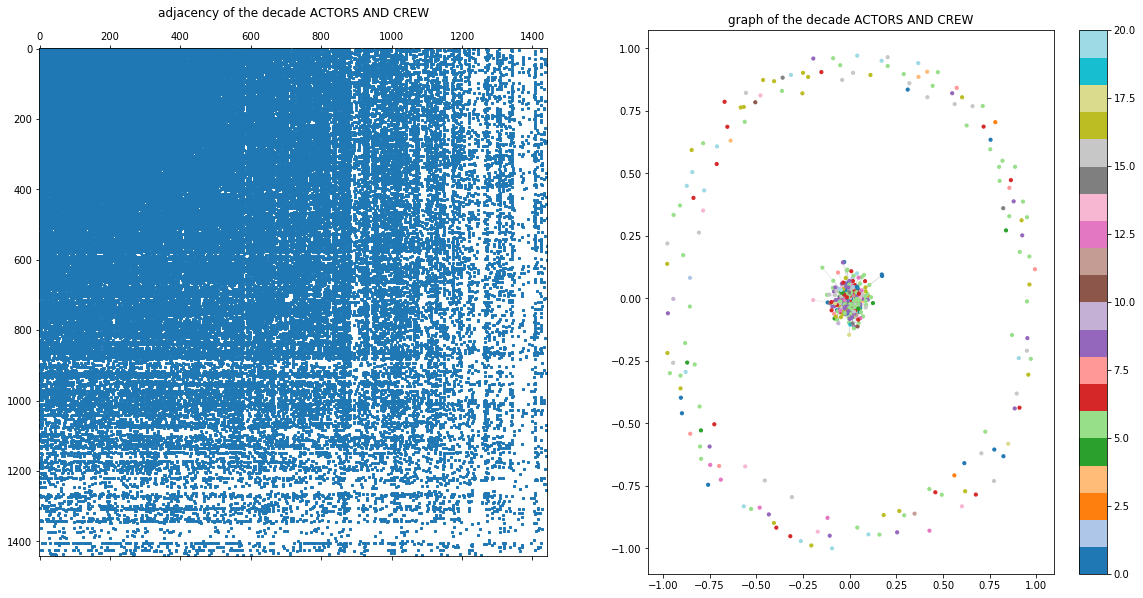

In [12]:
#Ici on fait le graph des films liés par les acteurs ET LE CREW
#On voit que qu'il y a beaucoup de films "seuls", donc dans la prochaine celle on fait pareil mais avec le giant component
adjacency_actors=np.load('./data/adjacency_actors_crew.npy')
moviesFilteredByYears
for i in range(numberOfDecades):
    lines_to_keep=moviesFilteredByYears[i].index
    adjacency_tot=adjacency_actors.copy()
    adjacency_decade_filtered=adjacency_tot[lines_to_keep,:]
    adjacency_decade_filtered=adjacency_decade_filtered[:,lines_to_keep]
    
    plt.figure(figsize=(20, 10))
    plt.subplot(121)
    plt.spy(adjacency_decade_filtered, markersize=2)
    plt.title('adjacency of the decade ACTORS AND CREW')
    
    G_decade = nx.from_numpy_matrix(adjacency_decade_filtered)
    #Gc_test = max(nx.connected_component_subgraphs(G_test), key=len)
    coords_decade = nx.spring_layout(G_decade,k=0.03)  
    labels = moviesFilteredByYears[i]['genres'].iloc[np.sort(nx.nodes(G_decade))]
    
    plt.subplot(122)
    im=nx.draw_networkx_nodes(G_decade, coords_decade, node_size=10,node_color=labels, cmap='tab20')
    nx.draw_networkx_edges(G_decade, coords_decade, alpha=0.1, width=0.7)
    plt.title('graph of the decade ACTORS AND CREW')
    plt.colorbar(im);

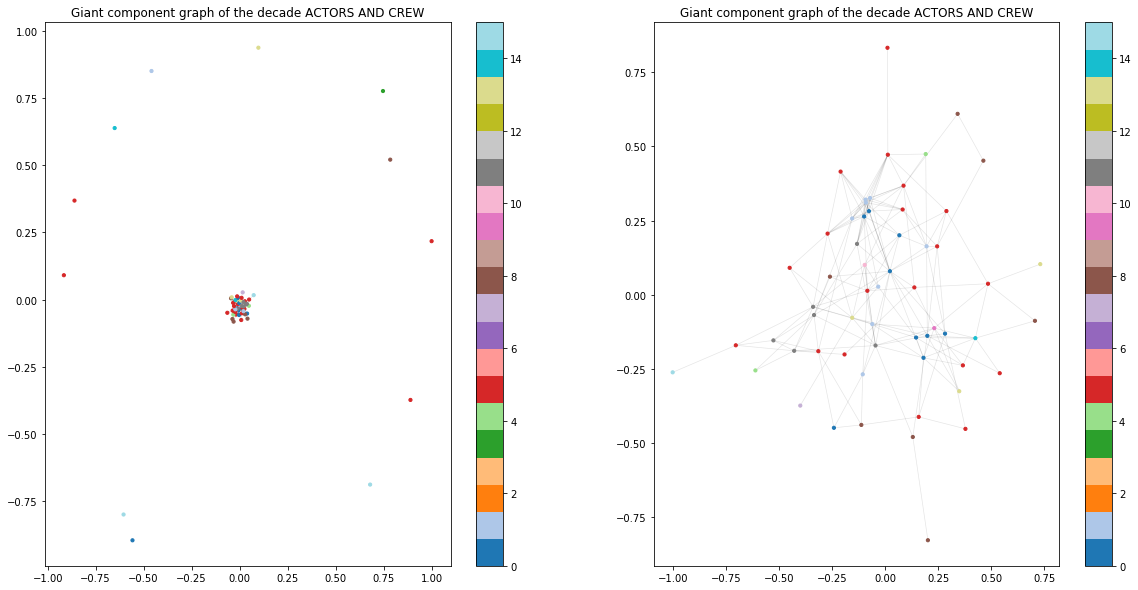

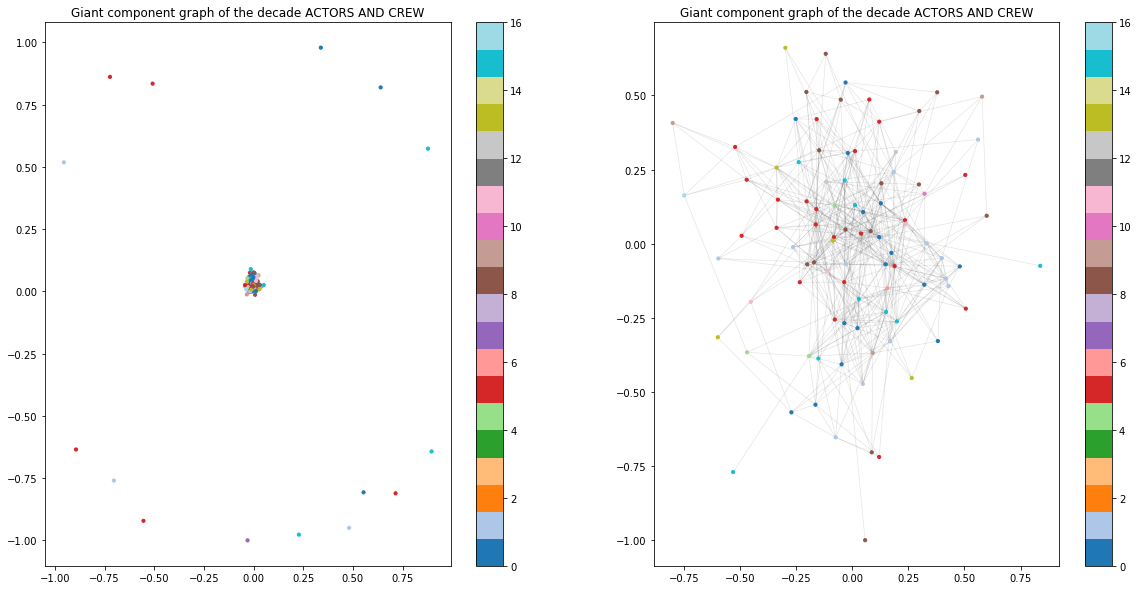

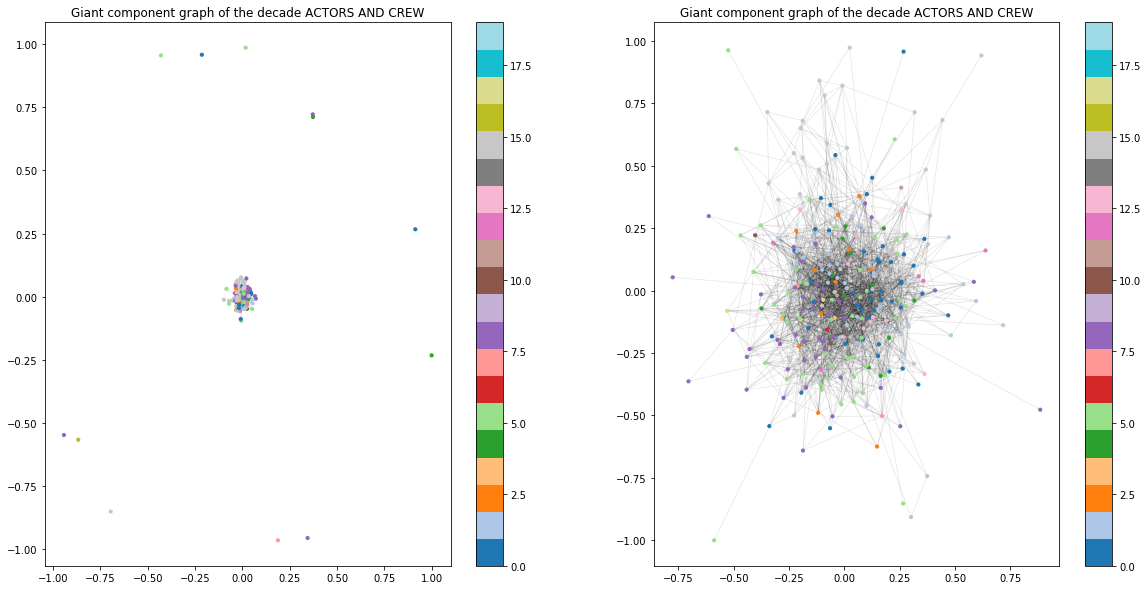

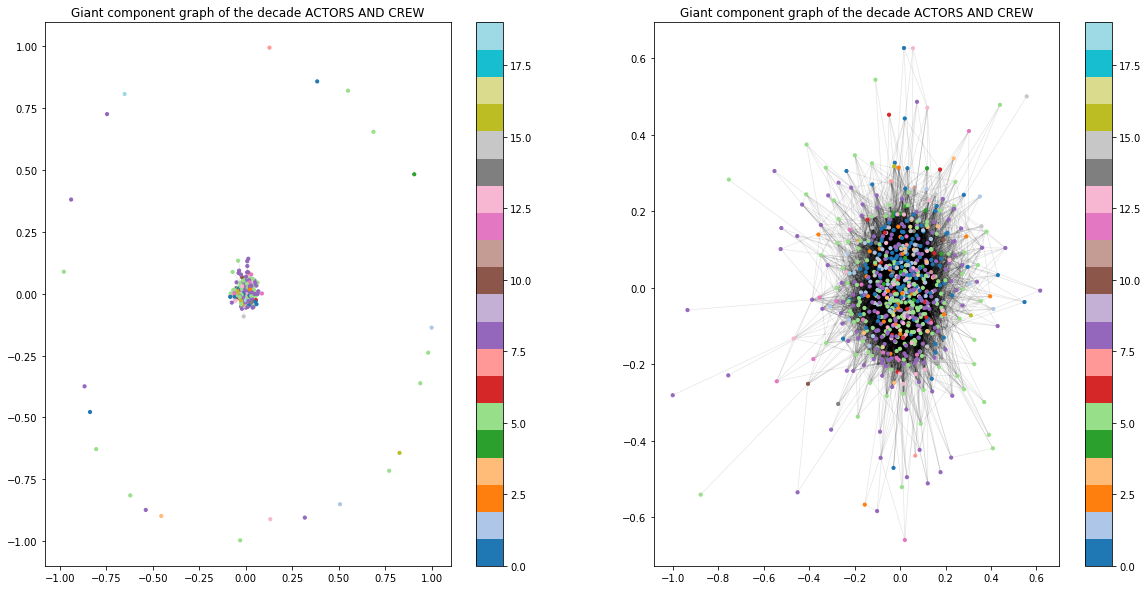

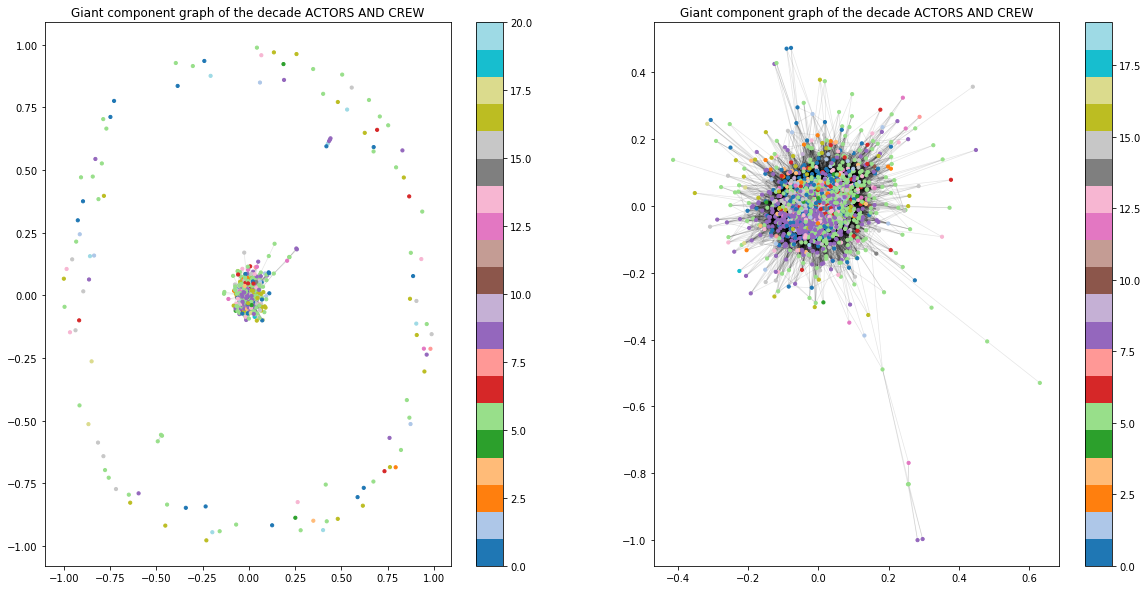

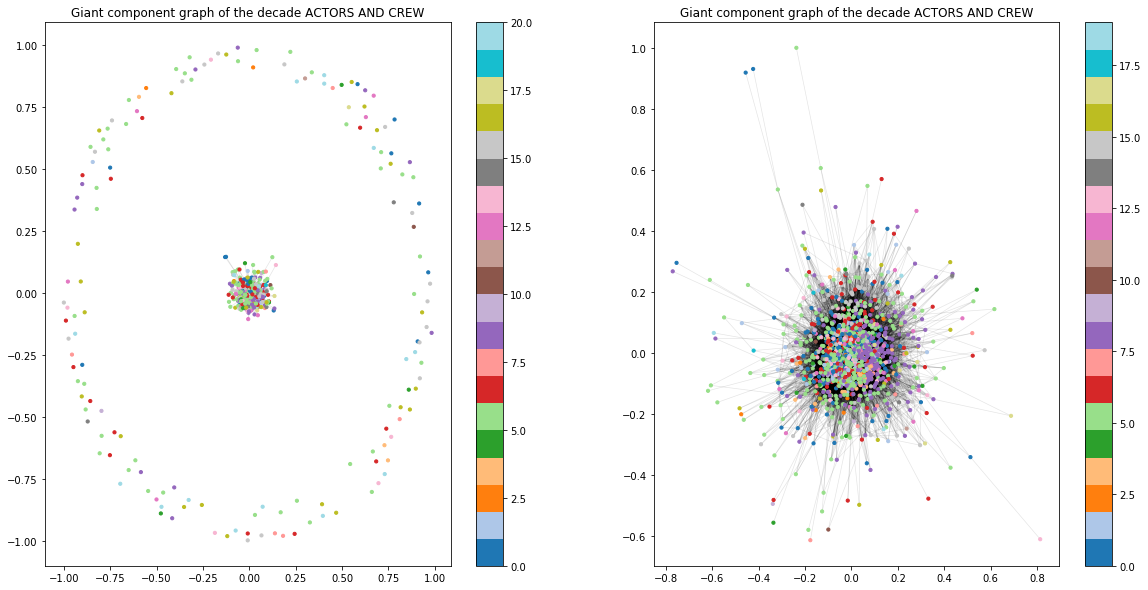

In [13]:
#ICI LES MEME GRAPHS MAIS AVEC LE GIANT COMPONENT
for i in range(numberOfDecades):
    lines_to_keep=moviesFilteredByYears[i].index
    adjacency_tot=adjacency_actors.copy()
    adjacency_decade_filtered=adjacency_tot[lines_to_keep,:]
    adjacency_decade_filtered=adjacency_decade_filtered[:,lines_to_keep]
    
    plt.figure(figsize=(20, 10))
    
    G_decade = nx.from_numpy_matrix(adjacency_decade_filtered)
    #Gc_test = max(nx.connected_component_subgraphs(G_test), key=len)
    coords_decade = nx.spring_layout(G_decade,k=0.03)  
    labels = moviesFilteredByYears[i]['genres'].iloc[np.sort(nx.nodes(G_decade))]
    plt.subplot(121)
    im=nx.draw_networkx_nodes(G_decade, coords_decade, node_size=10,node_color=labels, cmap='tab20')
    nx.draw_networkx_edges(G_decade, coords_decade, alpha=0.1, width=0.7)
    plt.title('Giant component graph of the decade ACTORS AND CREW')
    plt.colorbar(im);
    
    Gc_decade = max(nx.connected_component_subgraphs(G_decade), key=len)
    coords_decade_Gc = nx.spring_layout(Gc_decade,k=0.03)  
    labels = moviesFilteredByYears[i]['genres'].iloc[np.sort(nx.nodes(Gc_decade))]
    plt.subplot(122)
    im=nx.draw_networkx_nodes(Gc_decade, coords_decade_Gc, node_size=10,node_color=labels, cmap='tab20')
    nx.draw_networkx_edges(Gc_decade, coords_decade_Gc, alpha=0.1, width=0.7)
    plt.title('Giant component graph of the decade ACTORS AND CREW')
    plt.colorbar(im);

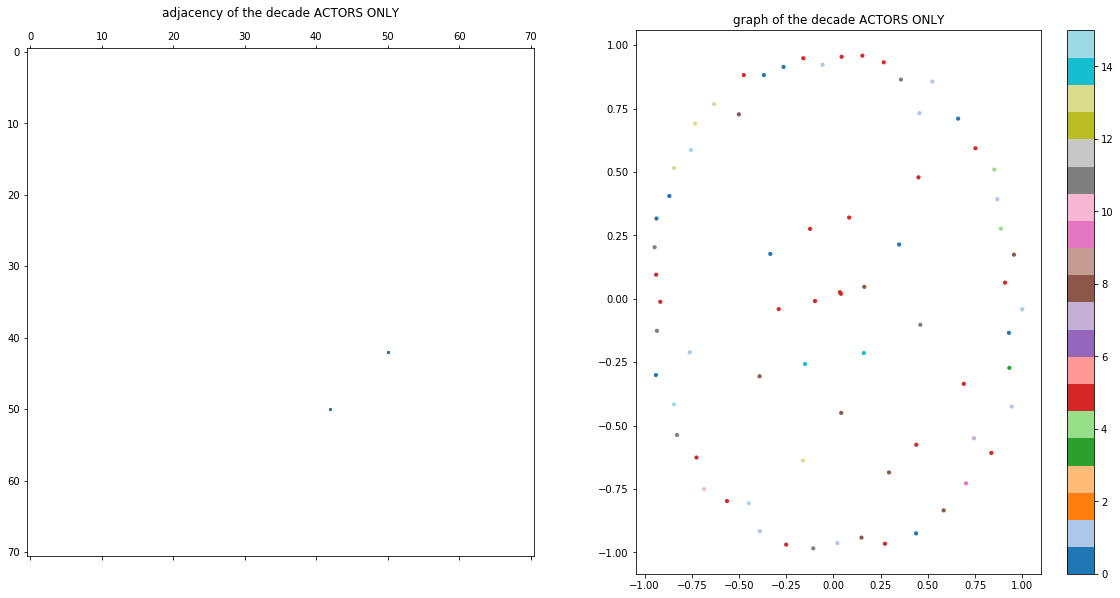

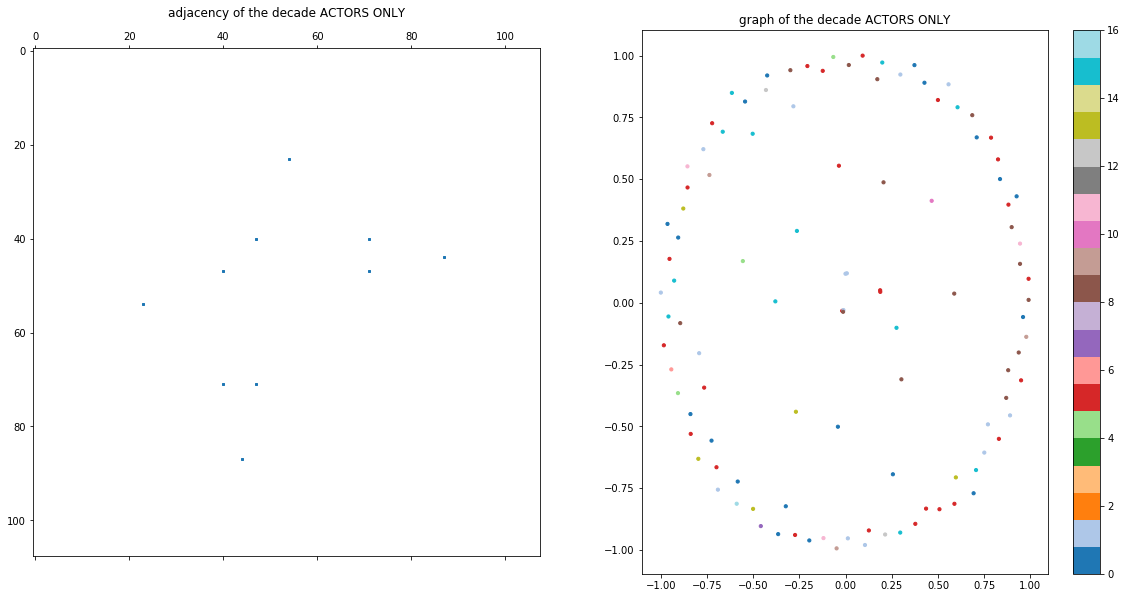

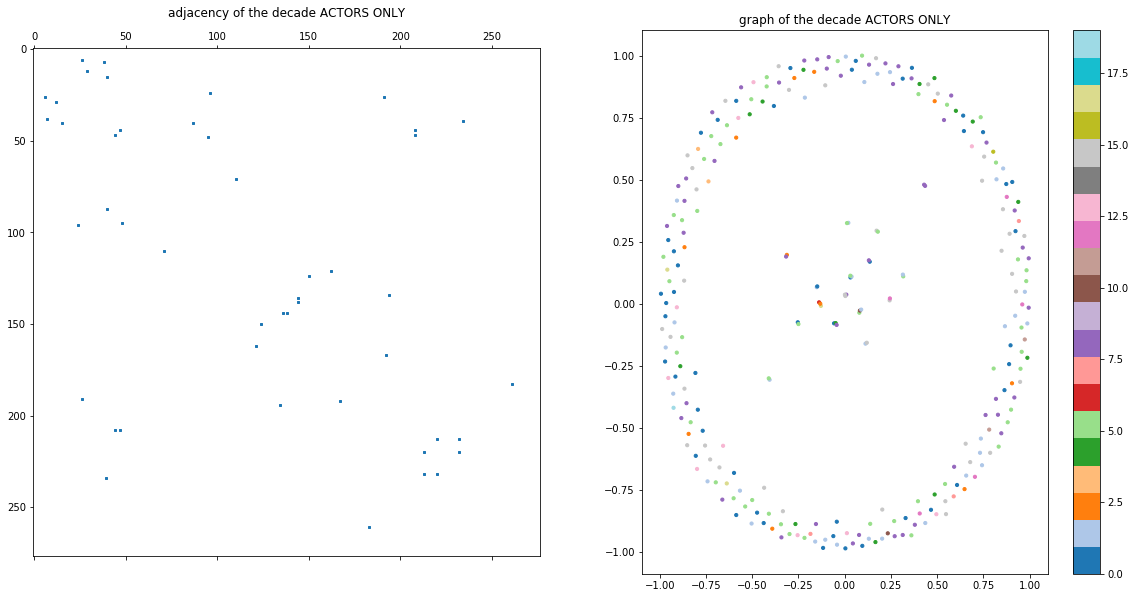

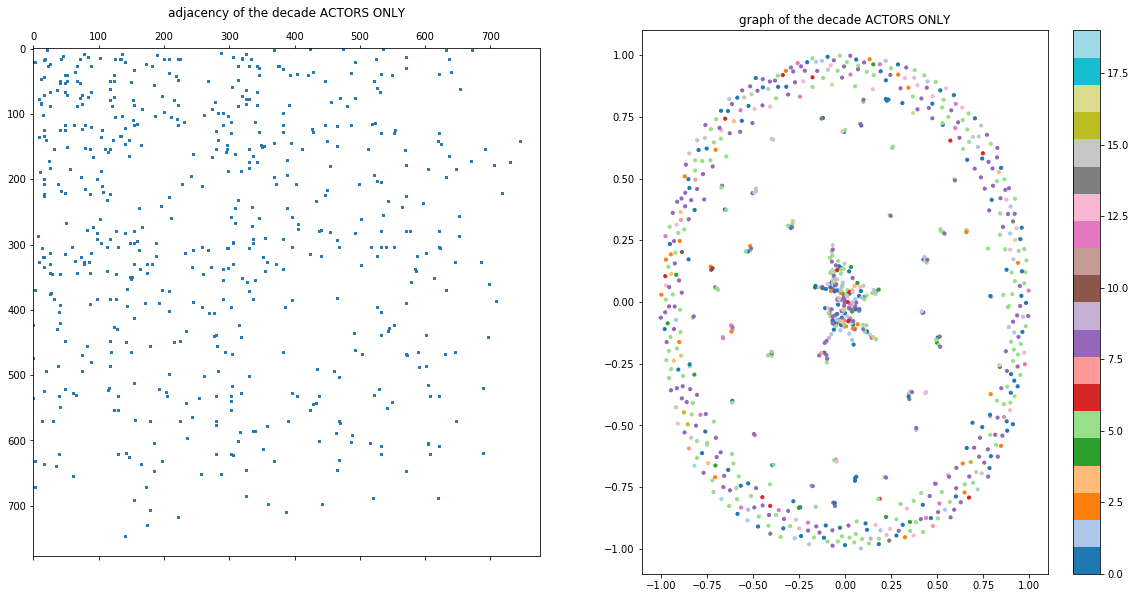

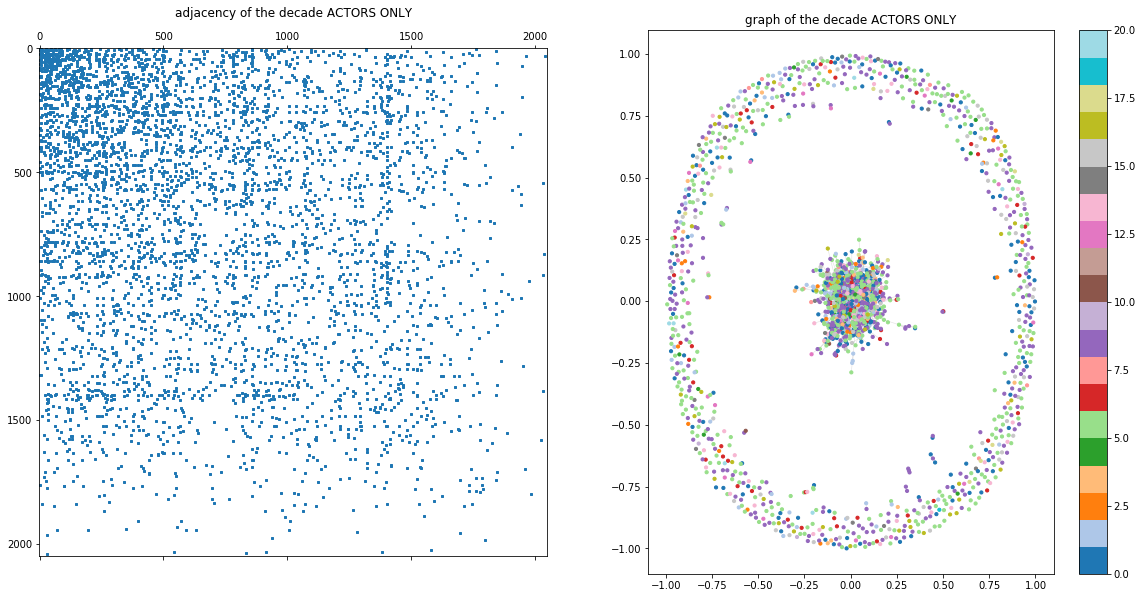

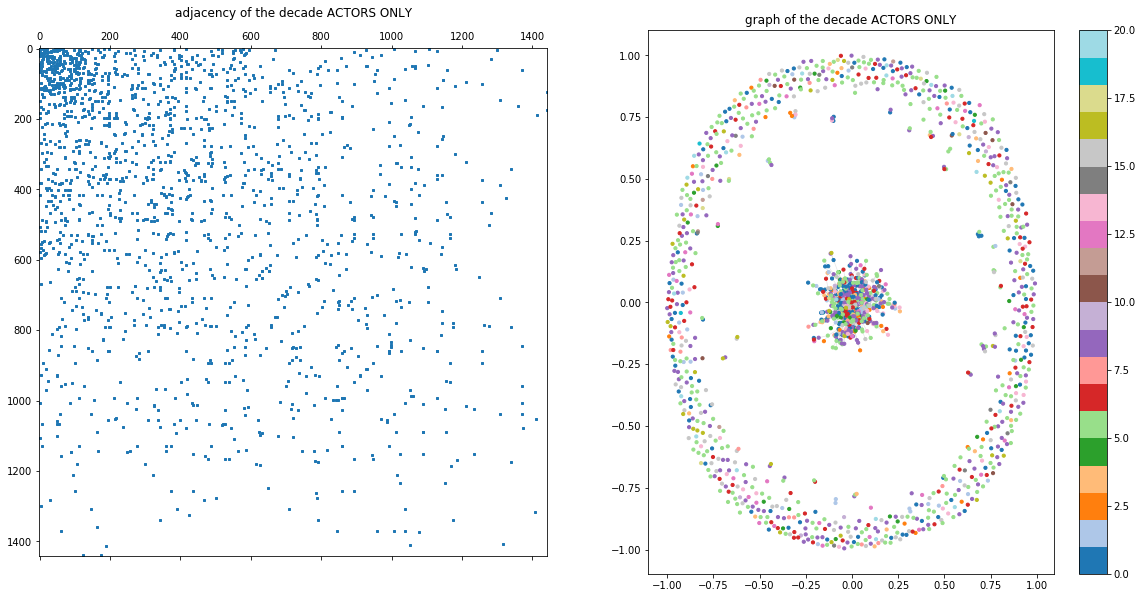

In [14]:
#Ici on fait le graph des films liés par les acteurs selon la décade
#On voit que qu'il y a beaucoup de films "seuls", donc dans la prochaine celle on fait pareil mais avec le giant component
adjacency_actors=np.load('./data/adjacency_actors_only.npy')
moviesFilteredByYears
for i in range(numberOfDecades):
    lines_to_keep=moviesFilteredByYears[i].index
    adjacency_tot=adjacency_actors.copy()
    adjacency_decade_filtered=adjacency_tot[lines_to_keep,:]
    adjacency_decade_filtered=adjacency_decade_filtered[:,lines_to_keep]
    
    plt.figure(figsize=(20, 10))
    plt.subplot(121)
    plt.spy(adjacency_decade_filtered, markersize=2)
    plt.title('adjacency of the decade ACTORS ONLY')
    
    G_decade = nx.from_numpy_matrix(adjacency_decade_filtered)
    #Gc_test = max(nx.connected_component_subgraphs(G_test), key=len)
    coords_decade = nx.spring_layout(G_decade,k=0.03)  
    labels = moviesFilteredByYears[i]['genres'].iloc[np.sort(nx.nodes(G_decade))]
    
    plt.subplot(122)
    im=nx.draw_networkx_nodes(G_decade, coords_decade, node_size=10,node_color=labels, cmap='tab20')
    nx.draw_networkx_edges(G_decade, coords_decade, alpha=0.1, width=0.7)
    plt.title('graph of the decade ACTORS ONLY')
    plt.colorbar(im);

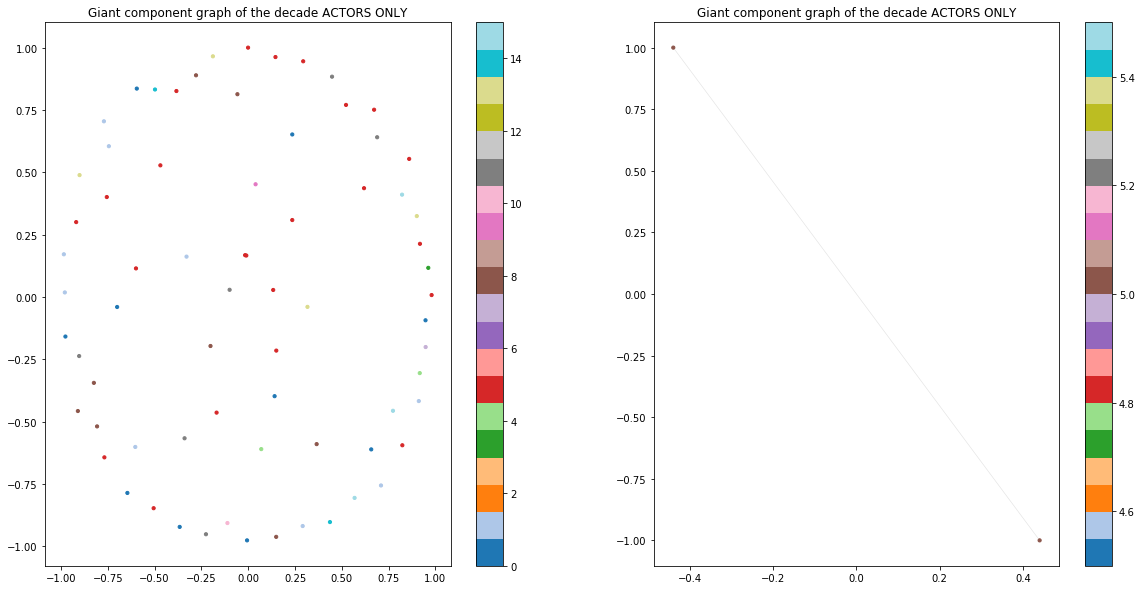

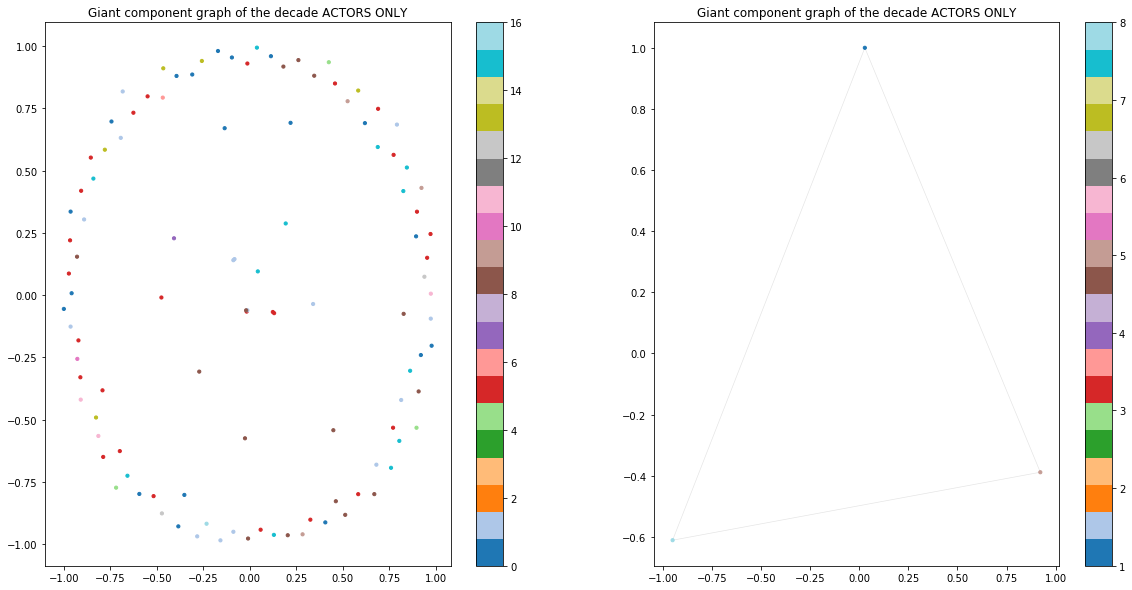

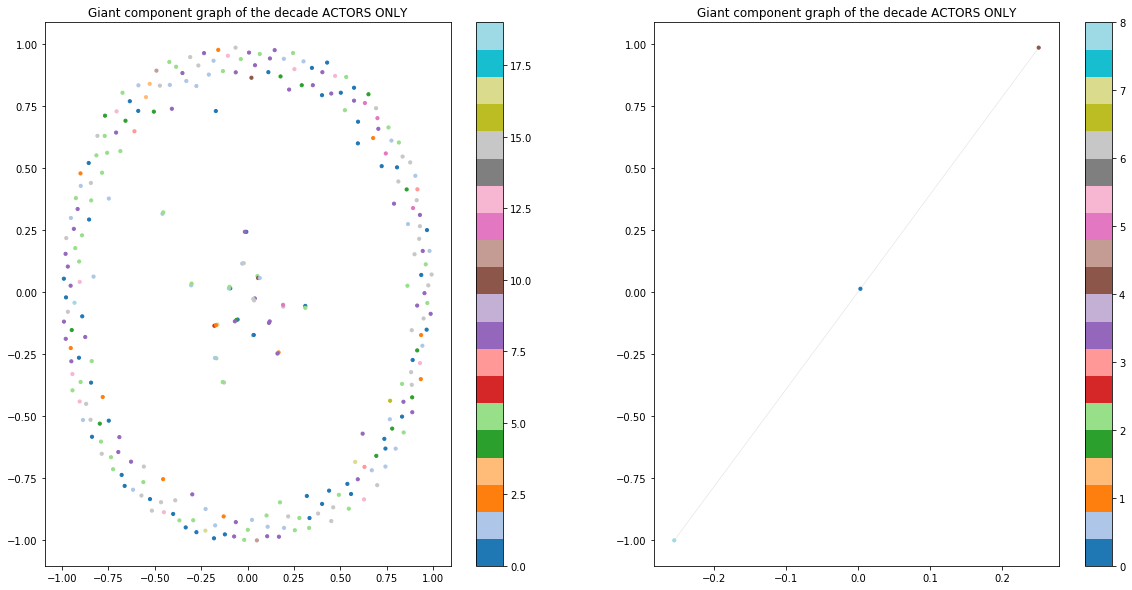

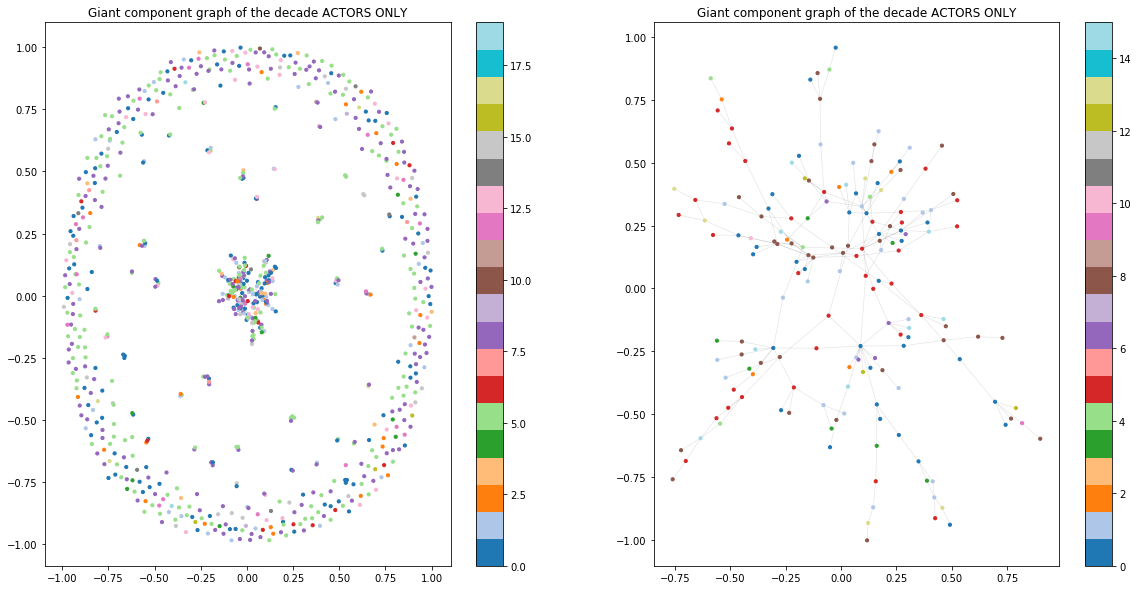

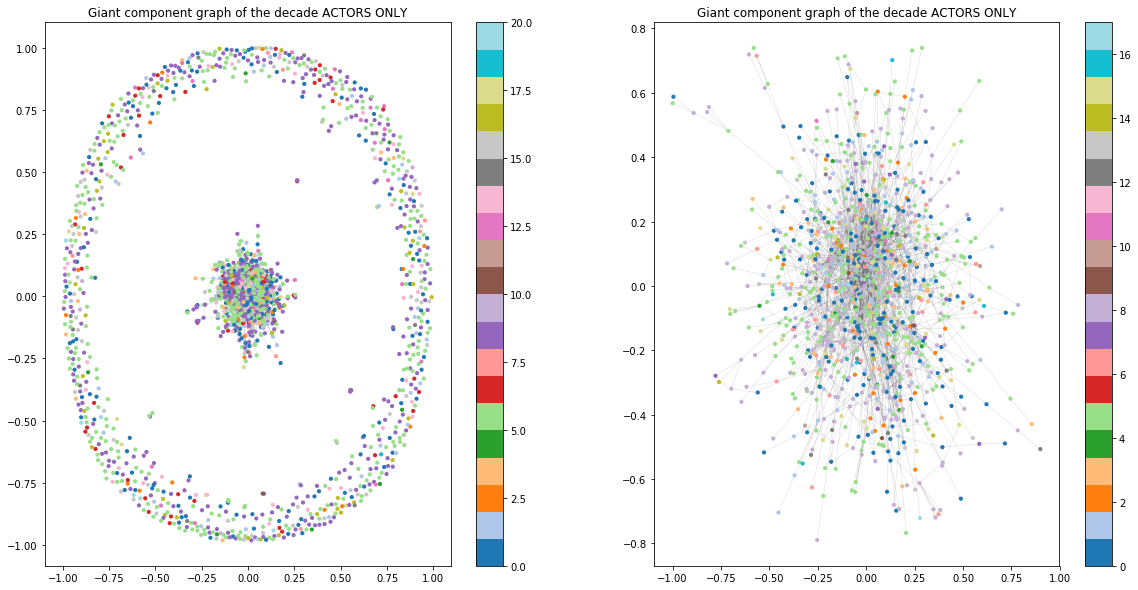

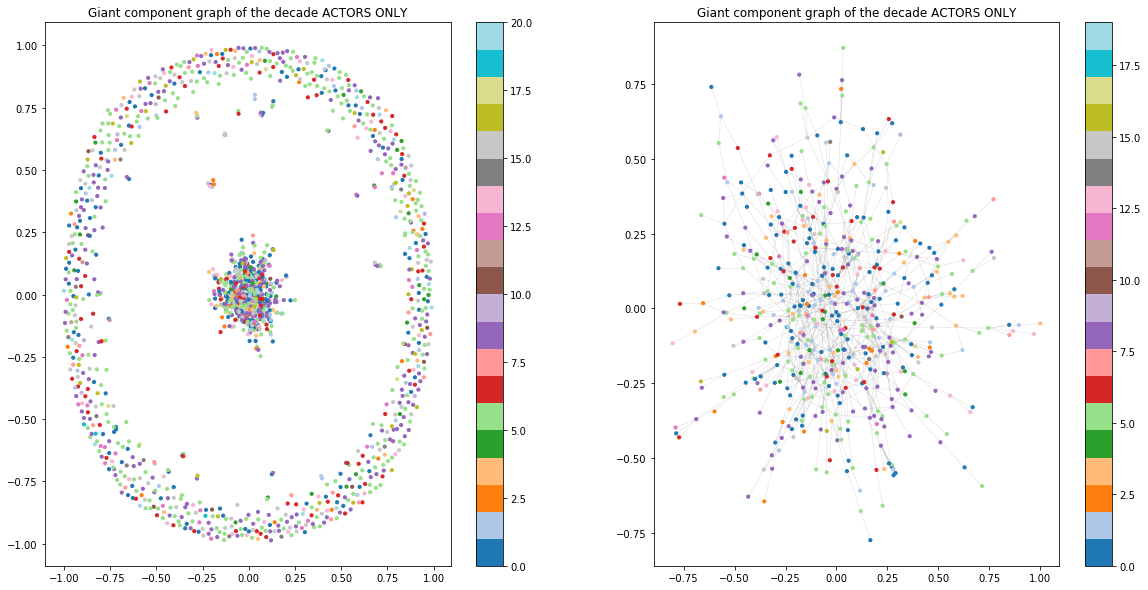

In [15]:
#ICI LES MEME GRAPHS MAIS AVEC LE GIANT COMPONENT
for i in range(numberOfDecades):
    lines_to_keep=moviesFilteredByYears[i].index
    adjacency_tot=adjacency_actors.copy()
    adjacency_decade_filtered=adjacency_tot[lines_to_keep,:]
    adjacency_decade_filtered=adjacency_decade_filtered[:,lines_to_keep]
    
    plt.figure(figsize=(20, 10))
    
    G_decade = nx.from_numpy_matrix(adjacency_decade_filtered)
    #Gc_test = max(nx.connected_component_subgraphs(G_test), key=len)
    coords_decade = nx.spring_layout(G_decade,k=0.03)  
    labels = moviesFilteredByYears[i]['genres'].iloc[np.sort(nx.nodes(G_decade))]
    plt.subplot(121)
    im=nx.draw_networkx_nodes(G_decade, coords_decade, node_size=10,node_color=labels, cmap='tab20')
    nx.draw_networkx_edges(G_decade, coords_decade, alpha=0.1, width=0.7)
    plt.title('Giant component graph of the decade ACTORS ONLY')
    plt.colorbar(im);
    
    Gc_decade = max(nx.connected_component_subgraphs(G_decade), key=len)
    coords_decade_Gc = nx.spring_layout(Gc_decade,k=0.03)  
    labels = moviesFilteredByYears[i]['genres'].iloc[np.sort(nx.nodes(Gc_decade))]
    plt.subplot(122)
    im=nx.draw_networkx_nodes(Gc_decade, coords_decade_Gc, node_size=10,node_color=labels, cmap='tab20')
    nx.draw_networkx_edges(Gc_decade, coords_decade_Gc, alpha=0.1, width=0.7)
    plt.title('Giant component graph of the decade ACTORS ONLY')
    plt.colorbar(im);

2019-01-13 18:58:46,147 | INFO : The budget max = 31115000
2019-01-13 18:58:46,149 | INFO : 862      2000000
1125    31115000
2140    20000000
2170      806948
2192    20000000
Name: budget, dtype: int64
2019-01-13 18:58:46,158 | INFO : The number of nodes is : 63


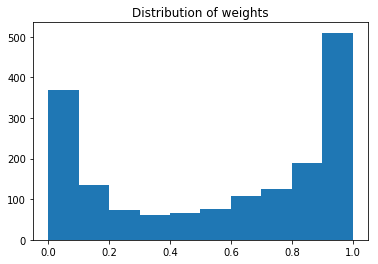

2019-01-13 18:58:46,358 | INFO : The number of edges is : 619
2019-01-13 18:58:46,359 | INFO : Adjacency done !
2019-01-13 18:58:46,375 | INFO : The budget max = 55000000
2019-01-13 18:58:46,377 | INFO : 813     55000000
1243      500000
1367    35000000
1403    35000000
1510    35000000
Name: budget, dtype: int64
2019-01-13 18:58:46,383 | INFO : The number of nodes is : 89


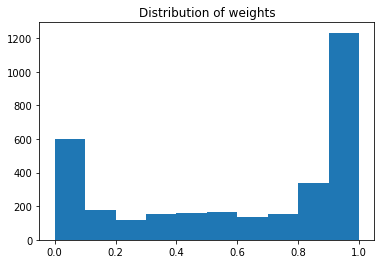

2019-01-13 18:58:46,548 | INFO : The number of edges is : 1444
2019-01-13 18:58:46,549 | INFO : Adjacency done !
2019-01-13 18:58:46,567 | INFO : The budget max = 70000000
2019-01-13 18:58:46,569 | INFO : 379    20000000
417     8000000
587    70000000
655     4200000
794    63000000
Name: budget, dtype: int64
2019-01-13 18:58:46,576 | INFO : The number of nodes is : 232


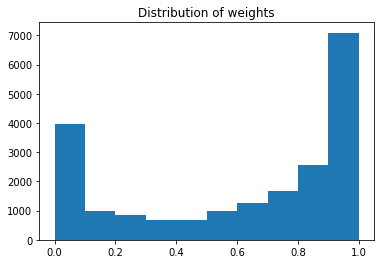

2019-01-13 18:58:46,745 | INFO : The number of edges is : 8570
2019-01-13 18:58:46,746 | INFO : Adjacency done !
2019-01-13 18:58:46,785 | INFO : The budget max = 200000000
2019-01-13 18:58:46,788 | INFO : 25     200000000
70     170000000
75     175000000
149    140000000
164    140000000
Name: budget, dtype: int64
2019-01-13 18:58:46,796 | INFO : The number of nodes is : 622


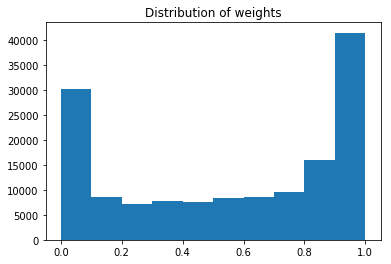

2019-01-13 18:58:47,014 | INFO : The number of edges is : 50384
2019-01-13 18:58:47,015 | INFO : Adjacency done !
2019-01-13 18:58:47,201 | INFO : The budget max = 300000000
2019-01-13 18:58:47,202 | INFO : 0     237000000
1     300000000
5     258000000
8     250000000
10    270000000
Name: budget, dtype: int64
2019-01-13 18:58:47,213 | INFO : The number of nodes is : 1554


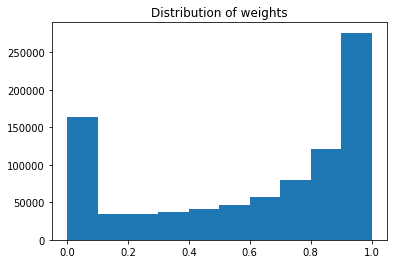

2019-01-13 18:58:47,474 | INFO : The number of edges is : 342932
2019-01-13 18:58:47,475 | INFO : Adjacency done !
2019-01-13 18:58:48,699 | INFO : The budget max = 380000000
2019-01-13 18:58:48,701 | INFO : 2    245000000
3    250000000
4    260000000
6    260000000
7    280000000
Name: budget, dtype: int64
2019-01-13 18:58:48,711 | INFO : The number of nodes is : 1139


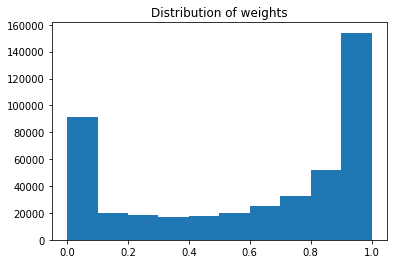

2019-01-13 18:58:48,952 | INFO : The number of edges is : 182874
2019-01-13 18:58:48,954 | INFO : Adjacency done !


In [16]:
#(adjacency, movies_by_budget) = ldata.make_budget_based_adjacency(movies);

adjacenciesFilteredByYears = []
moviesByBudgetFilteredByYears = []
genreOfMoviesFilteredByYears=[]
graphsFilteredByYears = []

for moviesData in moviesFilteredByYears:
    (adjacency, moviesByBudget,genreOfMovies) = ldata.make_budget_based_adjacency(moviesData,list_of_genres_id);
    adjacenciesFilteredByYears.append(adjacency);
    moviesByBudgetFilteredByYears.append(moviesByBudget)
    genreOfMoviesFilteredByYears.append(genreOfMovies)
    graphsFilteredByYears.append(pg.graphs.Graph(adjacency))



In [17]:
voteAvrgFtFilteredByYears = []
voteAvrgFilteredByYears = []

for i in range(len(graphsFilteredByYears)):
    voteAvrgFilteredByYears.append((moviesByBudgetFilteredByYears[i])['vote_average'].copy())
    (graphsFilteredByYears[i]).compute_fourier_basis()
    voteAvrgFtFilteredByYears.append(graphsFilteredByYears[i].gft((voteAvrgFilteredByYears[i]).values))

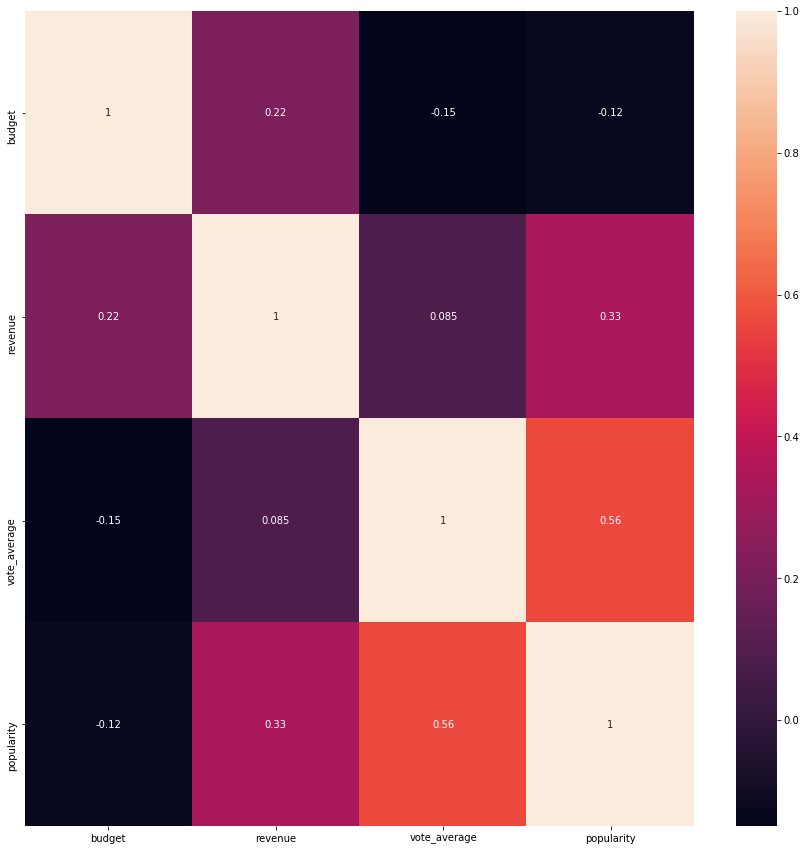

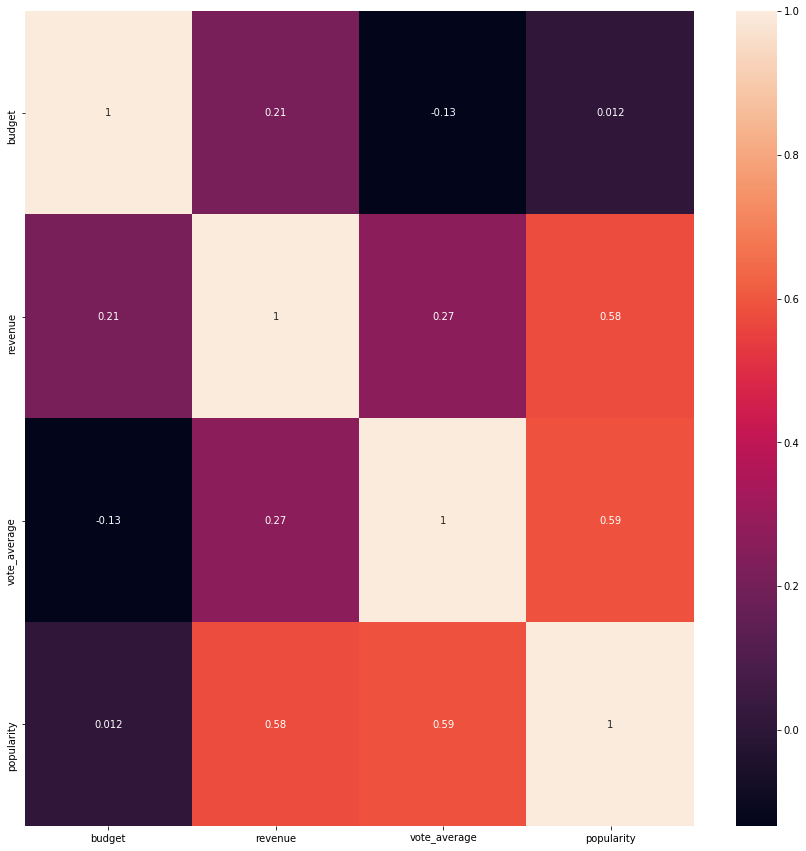

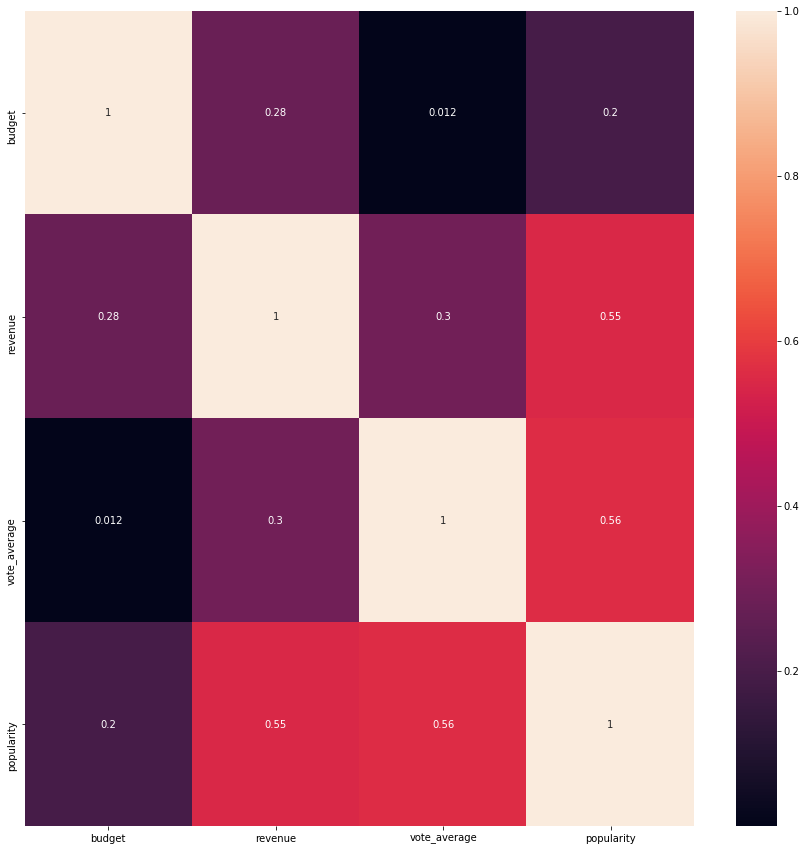

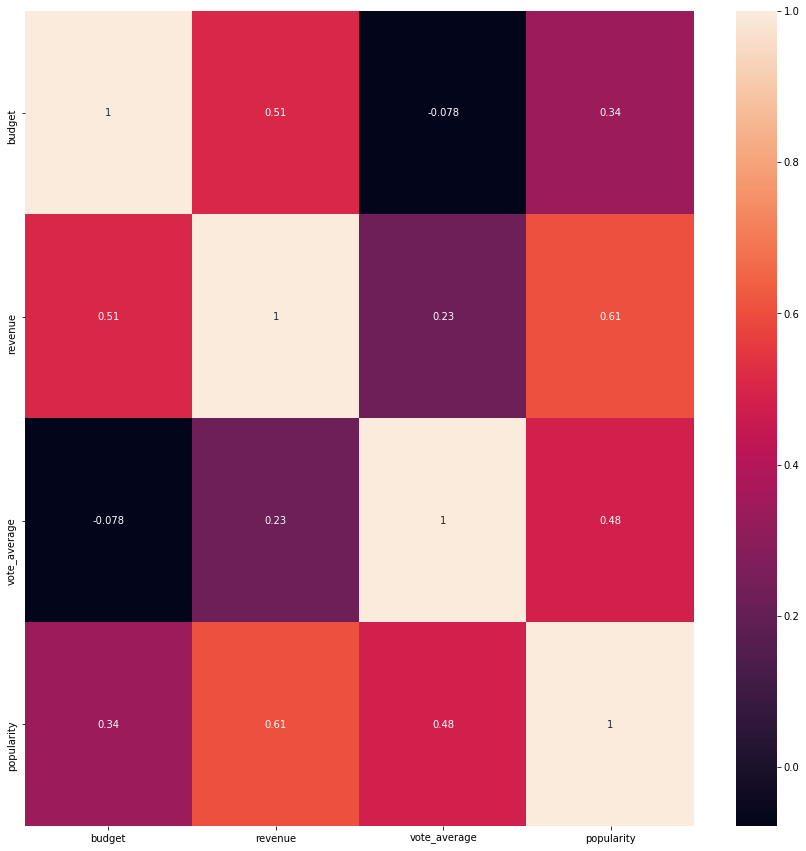

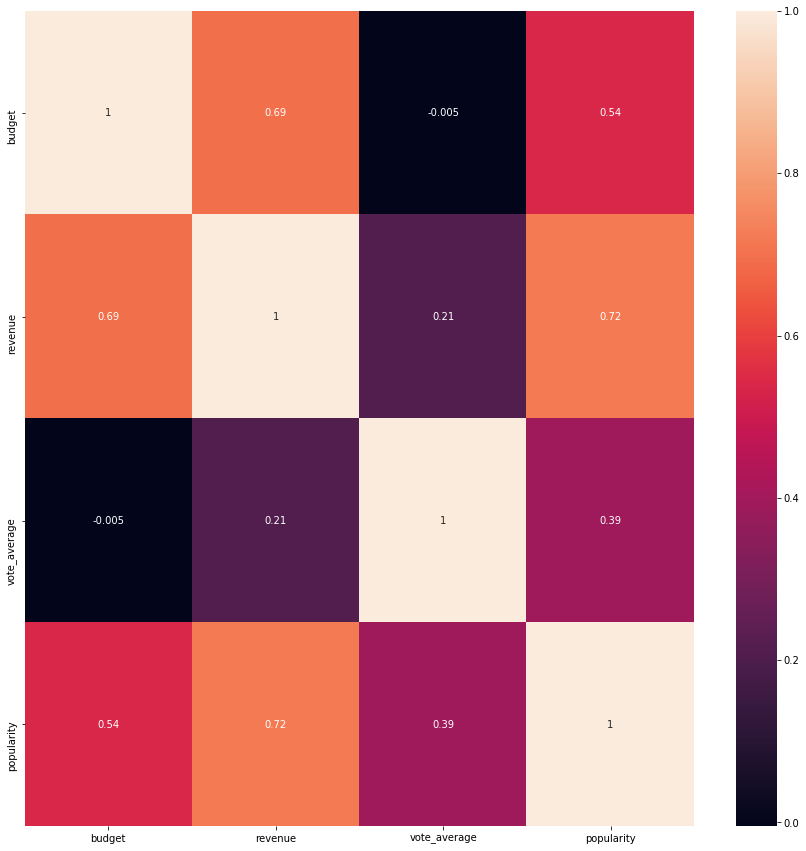

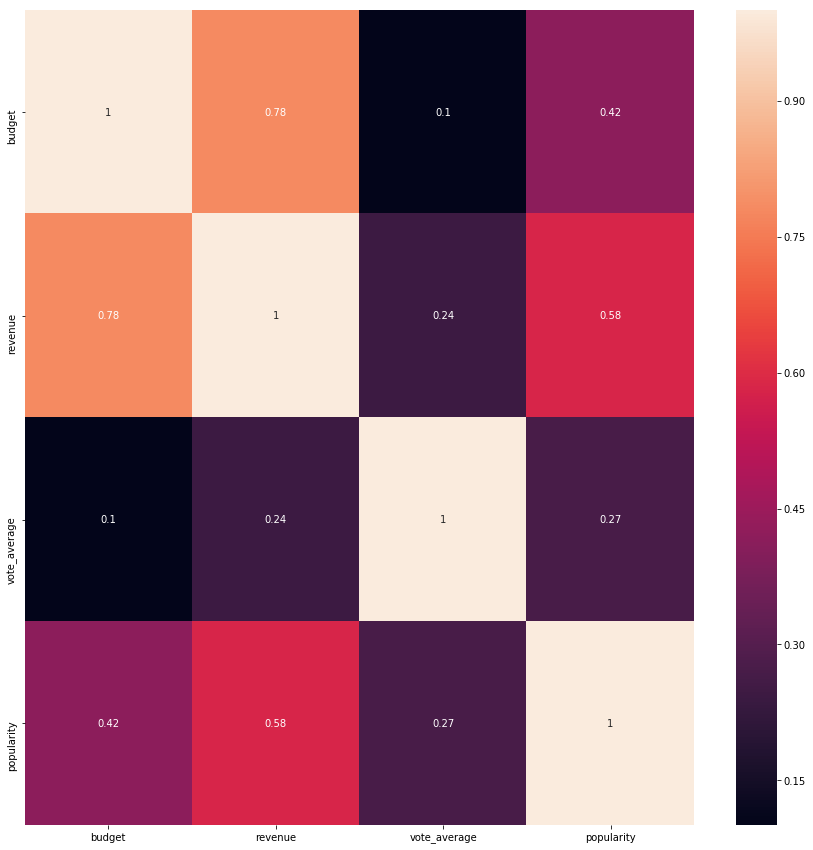

In [18]:
#find the correlation between parameters
#Je n'arrive pas à faire marcher le package sns --> je vais chercher une autre méthode


for i in range(len(graphsFilteredByYears)):
    plt.figure(figsize=(15, 15))
    data= moviesByBudgetFilteredByYears[i].loc[:, ['budget', 'revenue','vote_average','popularity']]
    sns.heatmap(data=data.corr(),annot=True)

In [19]:
i = 0
GCgraphsFilteredByYears=[]
CoordsSpringFilteredByYears=[]

for G in graphsFilteredByYears:  
    #creations des coordonées des giant component
    full_G = nx.from_numpy_matrix(adjacenciesFilteredByYears[i])
    Gc = max(nx.connected_component_subgraphs(full_G), key=len)
    adjacency= nx.to_numpy_array(Gc)
    GCgraphsFilteredByYears.append(Gc)
    CoordsSpringFilteredByYears.append(nx.spring_layout(Gc,k=0.03))
    
    i = i+1

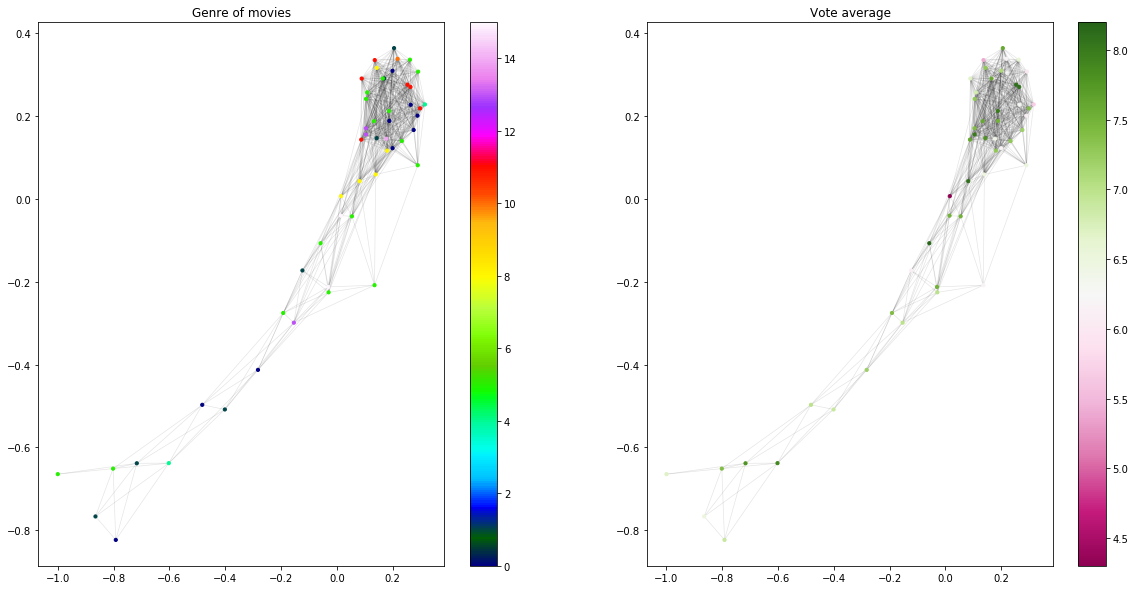

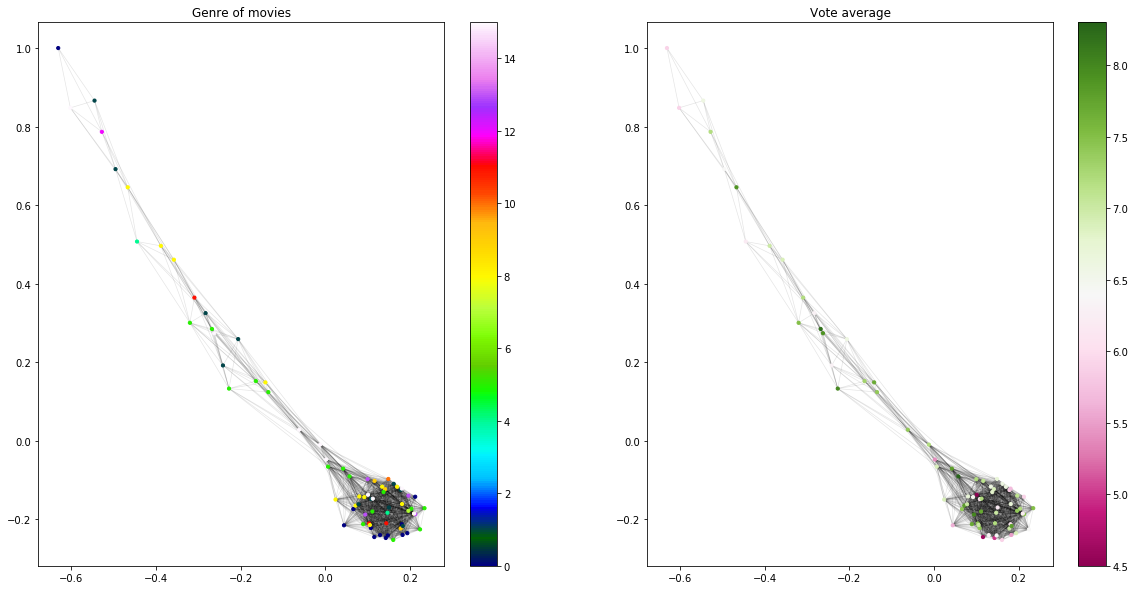

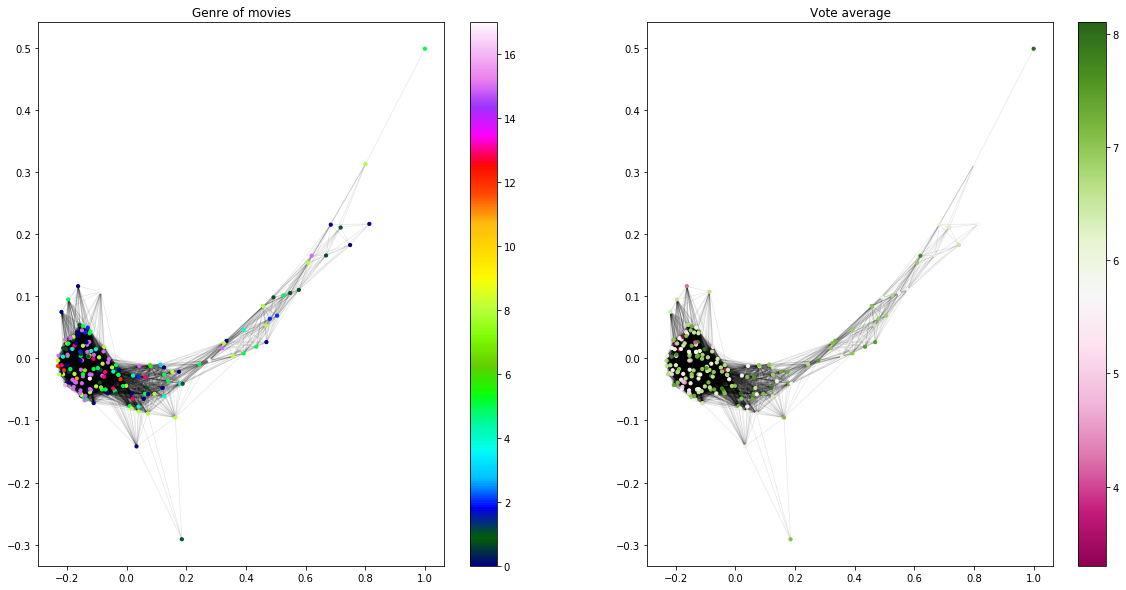

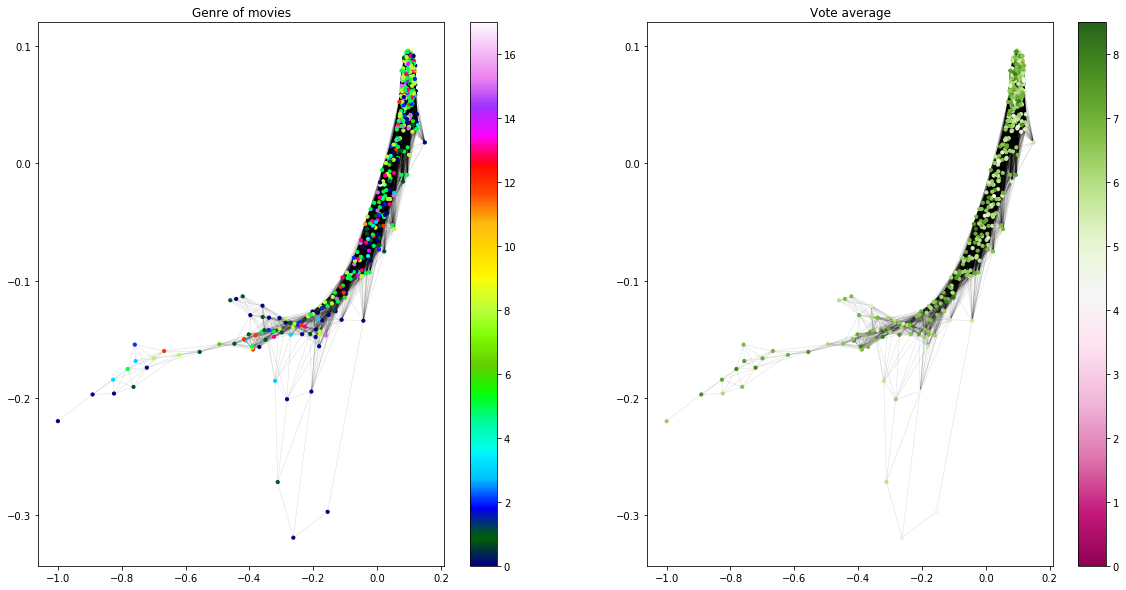

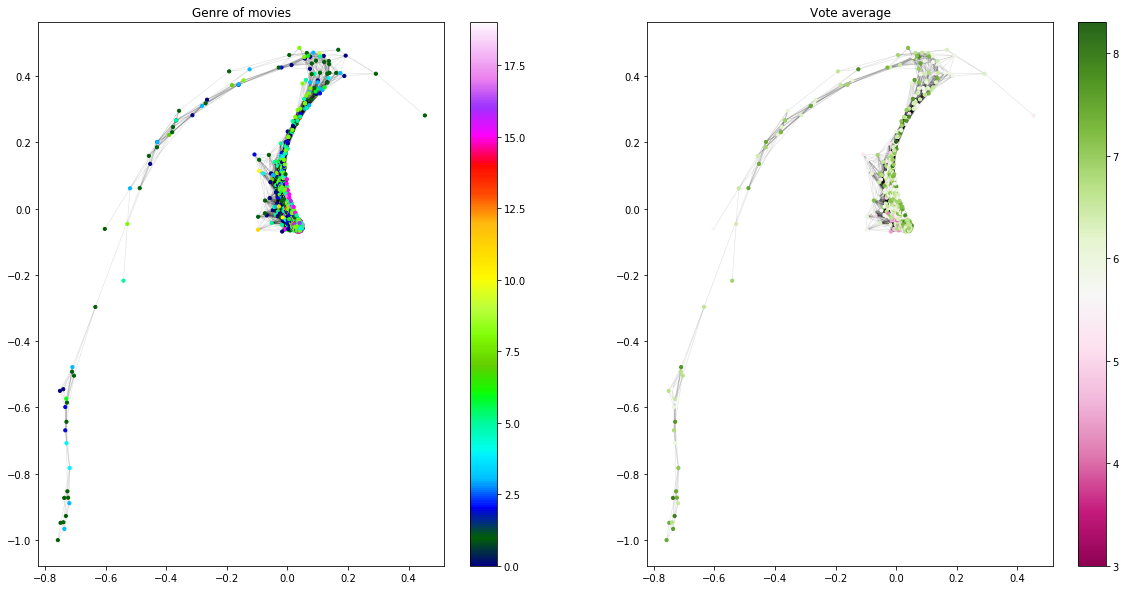

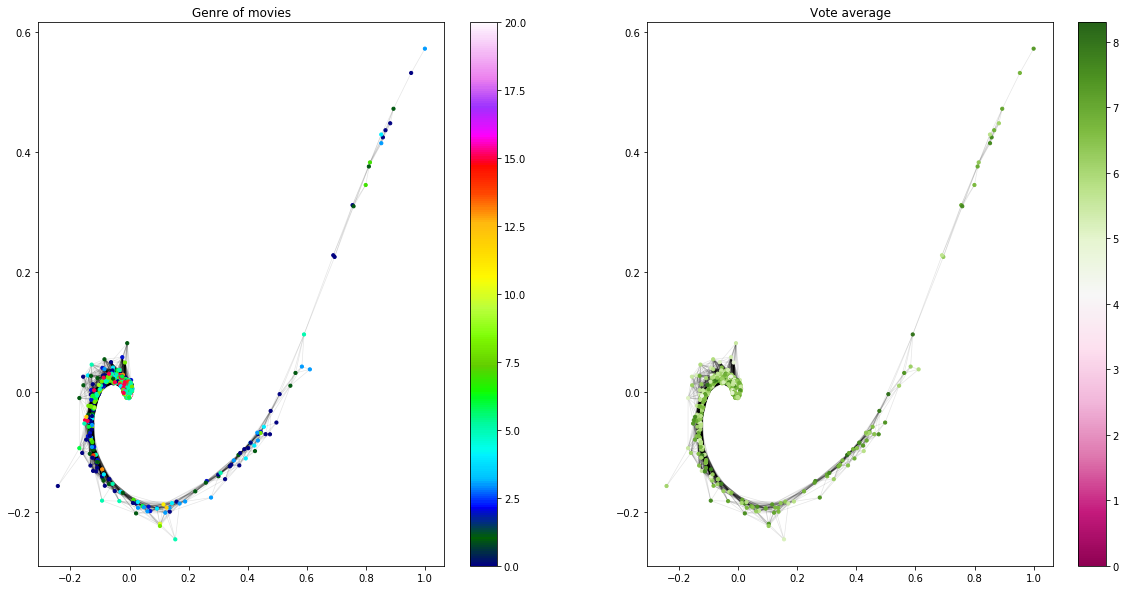

In [20]:
i = 0
for G in GCgraphsFilteredByYears:
    
    plt.figure(figsize=(20, 10))
    
    plt.subplot(121)
    labels = genreOfMoviesFilteredByYears[i].iloc[np.sort(nx.nodes(G))]
    coords_spring=CoordsSpringFilteredByYears[i]
    im=nx.draw_networkx_nodes(G, coords_spring, node_size=10, node_color=labels, cmap='gist_ncar')
    nx.draw_networkx_edges(G, coords_spring, alpha=0.1, width=0.7)
    plt.title('Genre of movies')
    plt.colorbar(im);
    
    plt.subplot(122)
    labels = voteAvrgFilteredByYears[i].iloc[np.sort(nx.nodes(G))]
    coords_spring=CoordsSpringFilteredByYears[i]
    im=nx.draw_networkx_nodes(G, coords_spring, node_size=10, node_color=labels, cmap='PiYG')
    nx.draw_networkx_edges(G, coords_spring, alpha=0.1, width=0.7)
    plt.title('Vote average')
    plt.colorbar(im);
        
    i=i+1
    

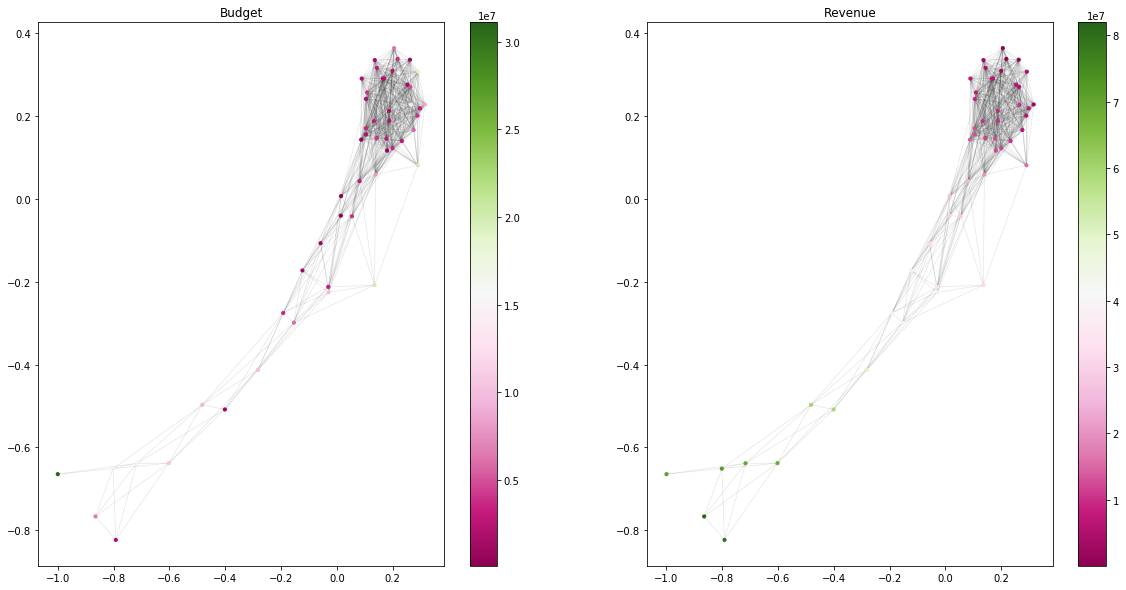

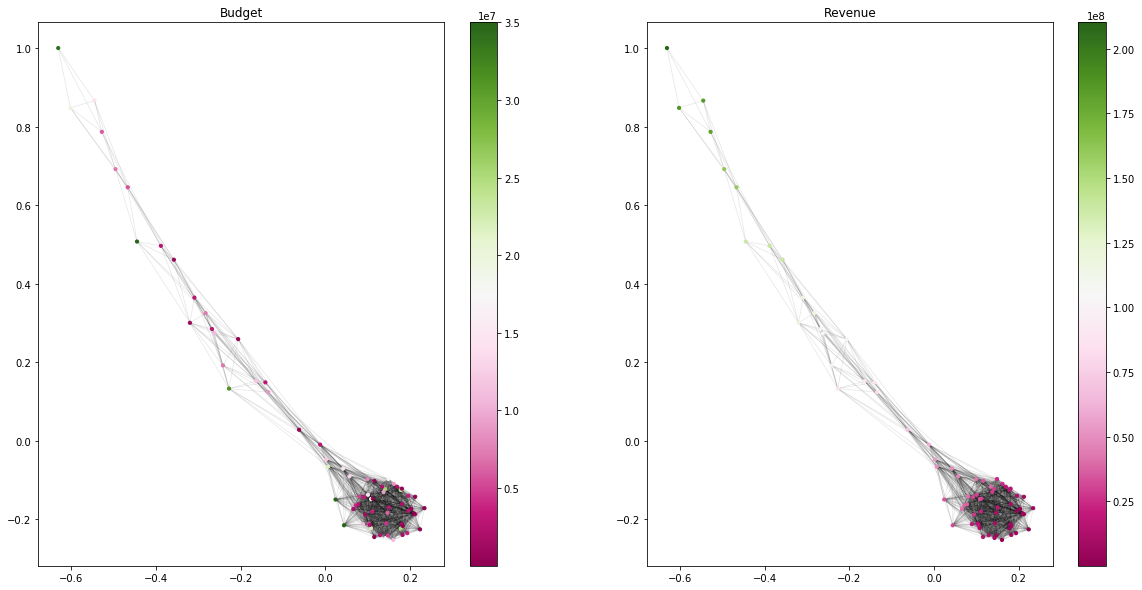

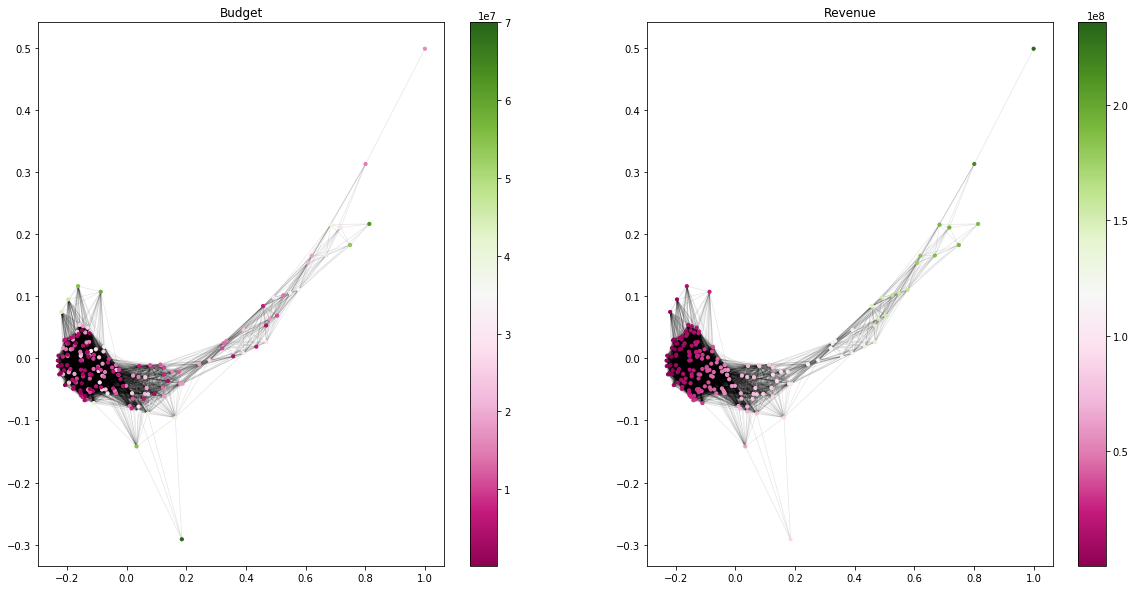

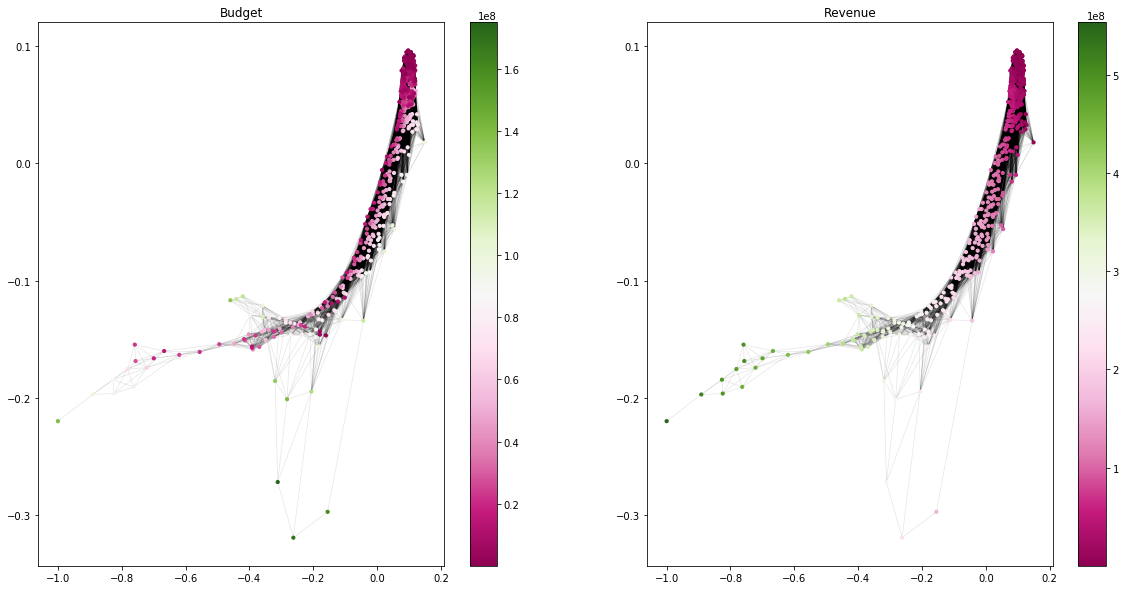

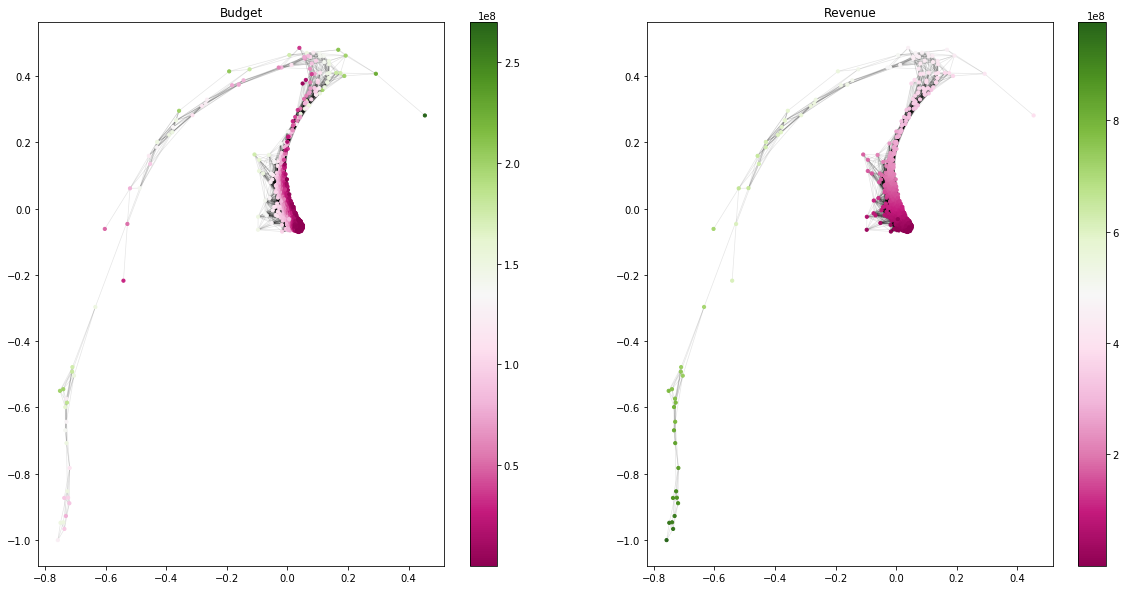

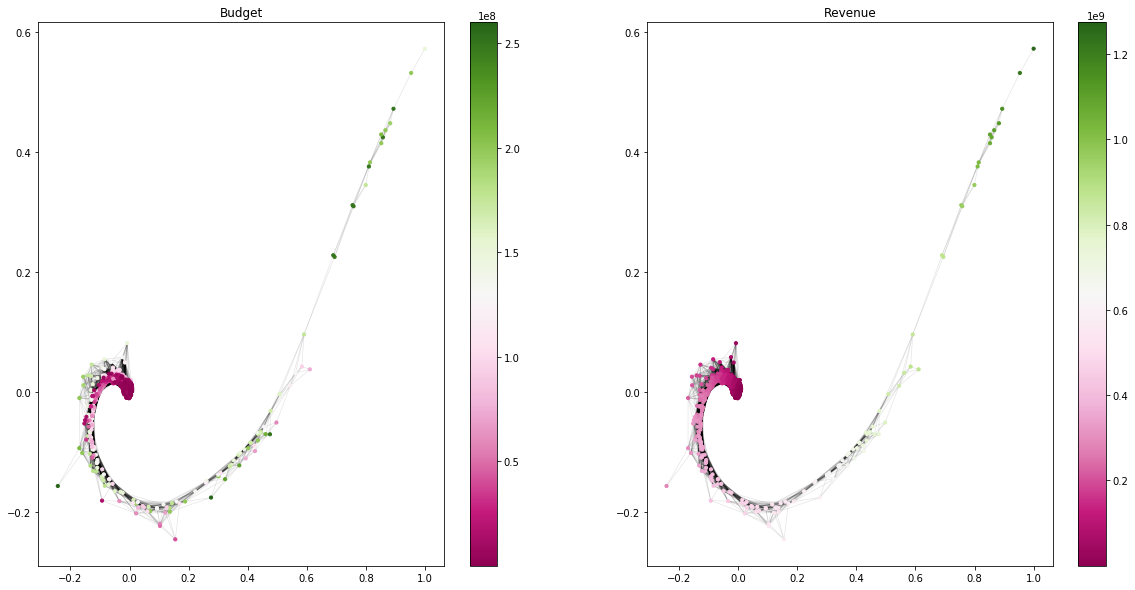

In [21]:
i = 0
for G in GCgraphsFilteredByYears:
    
    plt.figure(figsize=(20, 10))
    plt.subplot(121)
    labels = moviesByBudgetFilteredByYears[i]['budget'].iloc[np.sort(nx.nodes(G))]
    coords_spring=CoordsSpringFilteredByYears[i]
    im=nx.draw_networkx_nodes(G, coords_spring, node_size=10, node_color=labels, cmap='PiYG')
    nx.draw_networkx_edges(G, coords_spring, alpha=0.1, width=0.7)
    plt.title('Budget')
    plt.colorbar(im);
    
    plt.subplot(122)
    labels = moviesByBudgetFilteredByYears[i]['revenue'].iloc[np.sort(nx.nodes(G))]
    coords_spring=CoordsSpringFilteredByYears[i]
    im=nx.draw_networkx_nodes(G, coords_spring, node_size=10, node_color=labels, cmap='PiYG')
    nx.draw_networkx_edges(G, coords_spring, alpha=0.1, width=0.7)
    plt.title('Revenue')
    plt.colorbar(im);
        
    i=i+1

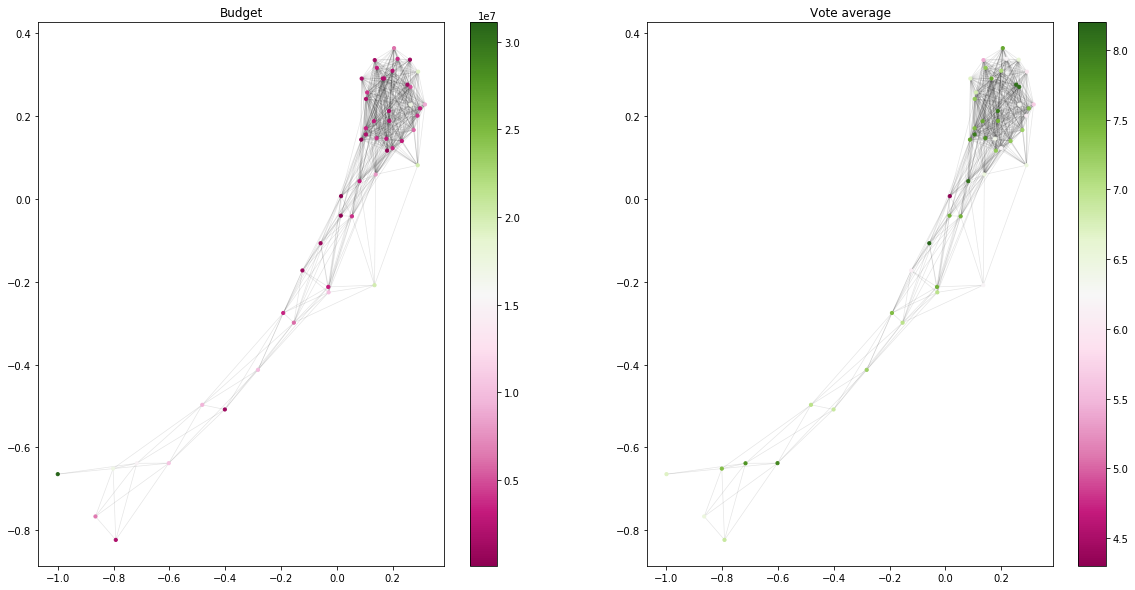

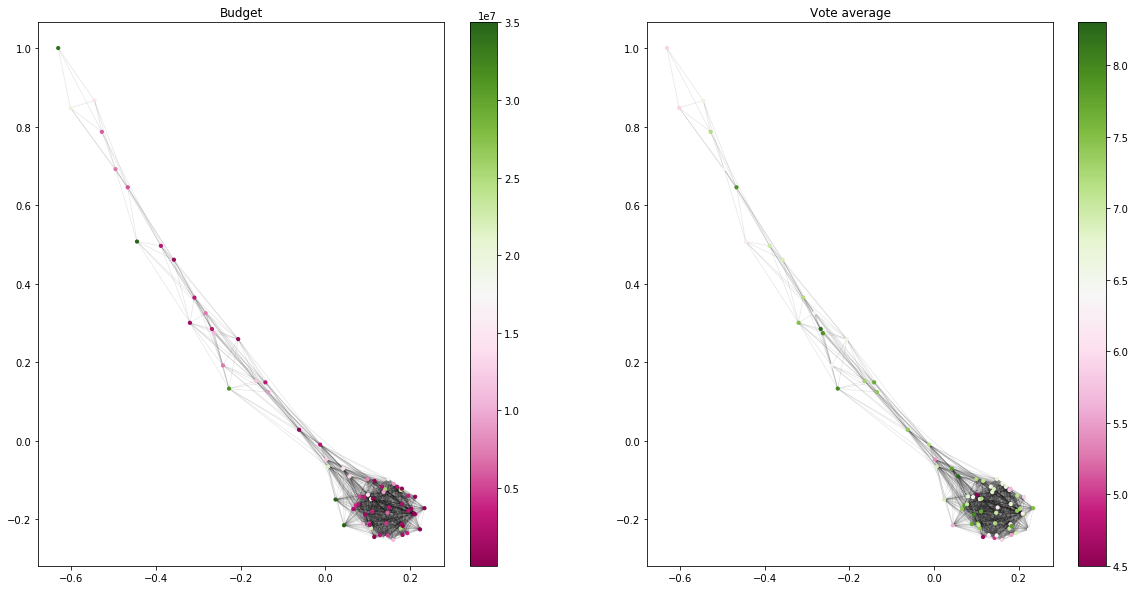

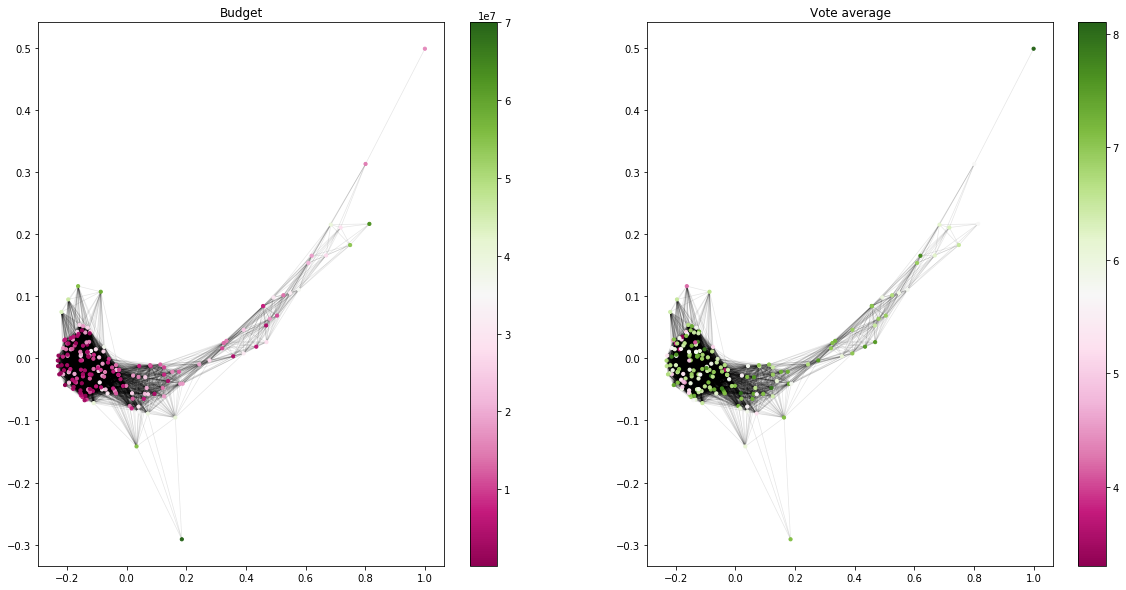

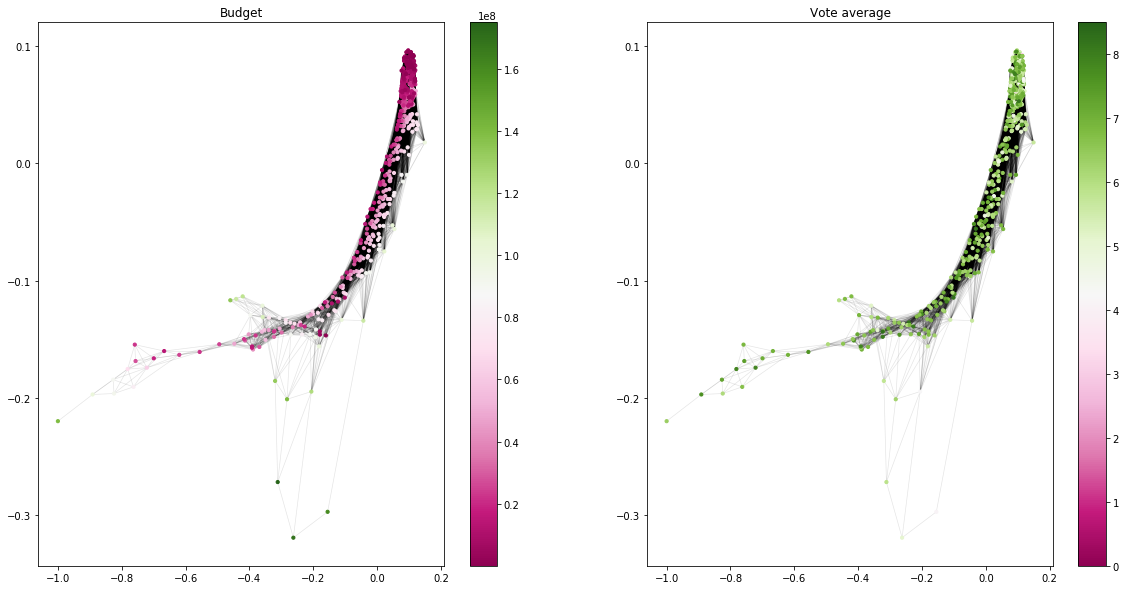

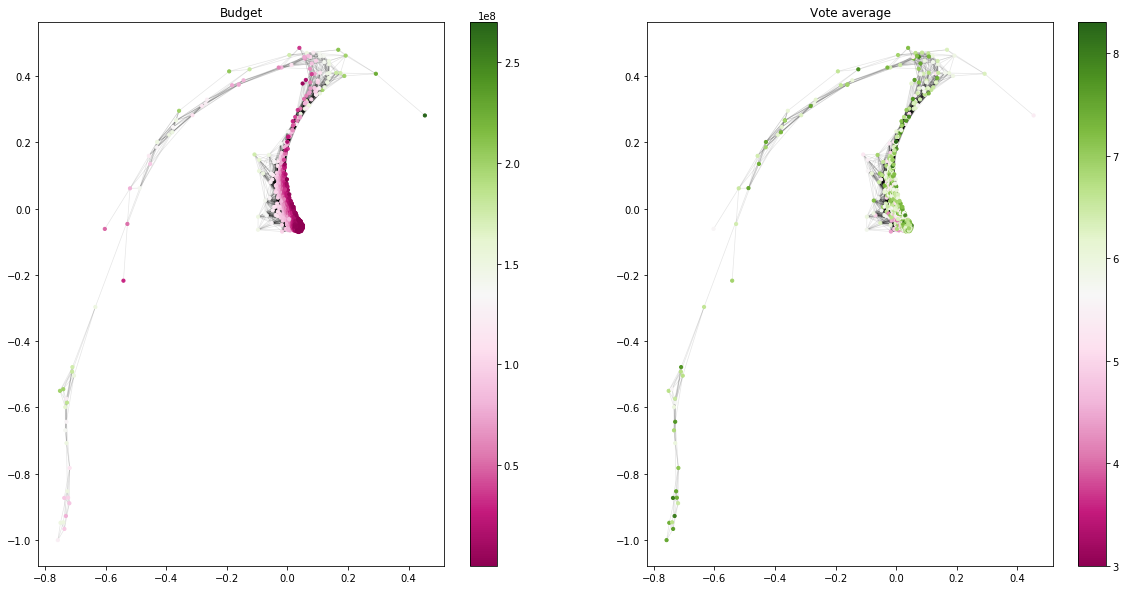

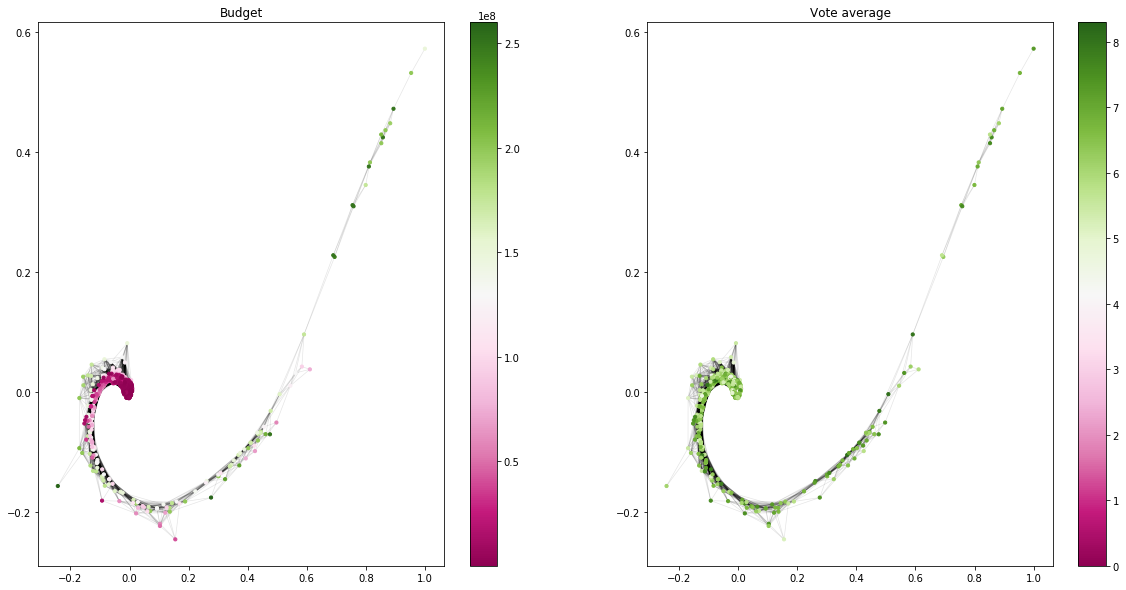

In [22]:
i = 0
for G in GCgraphsFilteredByYears:
    
    plt.figure(figsize=(20, 10))
    plt.subplot(121)
    labels = moviesByBudgetFilteredByYears[i]['budget'].iloc[np.sort(nx.nodes(G))]
    coords_spring=CoordsSpringFilteredByYears[i]
    im=nx.draw_networkx_nodes(G, coords_spring, node_size=10, node_color=labels, cmap='PiYG')
    nx.draw_networkx_edges(G, coords_spring, alpha=0.1, width=0.7)
    plt.title('Budget')
    plt.colorbar(im);
    
    plt.subplot(122)
    labels = moviesByBudgetFilteredByYears[i]['vote_average'].iloc[np.sort(nx.nodes(G))]
    coords_spring=CoordsSpringFilteredByYears[i]
    im=nx.draw_networkx_nodes(G, coords_spring, node_size=10, node_color=labels, cmap='PiYG')
    nx.draw_networkx_edges(G, coords_spring, alpha=0.1, width=0.7)
    plt.title('Vote average')
    plt.colorbar(im);
        
    i=i+1

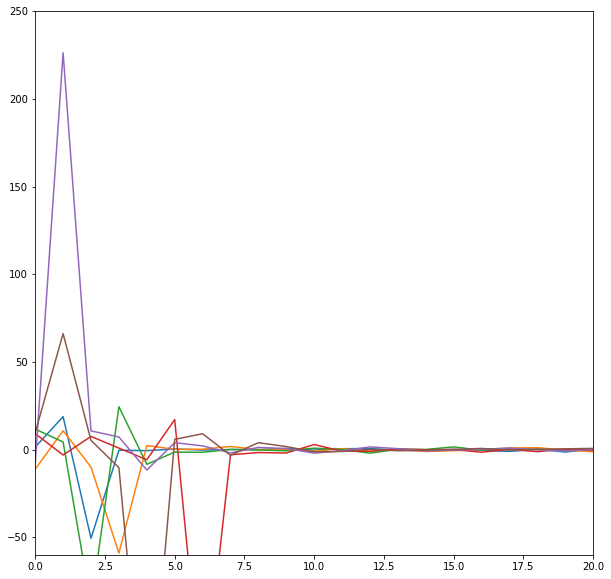

In [23]:
i=0
plt.figure(figsize=(10,10))
plt.axis([0,20,-60,250])
for G in graphsFilteredByYears:
    plt.plot(voteAvrgFtFilteredByYears[i])
    i=i+1
